In [1]:
import matplotlib.pyplot as plt

In [2]:
from pyspark import SparkConf
from pyspark.sql import SparkSession

import datetime
from datetime import timedelta
from pyspark.sql import functions as F
import pandas as pd
    
import os
os.environ['SPARK_HOME'] = '/opt/conda/lib/python3.7/site-packages/pyspark'
os.environ['PYSPARK_PYTHON'] = 'anaconda-2019.07.tar.gz/bin/python3'
os.environ['HADOOP_CONF_DIR'] = "/etc/hadoop/conf/"
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-8-openjdk-amd64'
 
host_ip = os.getenv('HOST_IP')
 
def start_spark_context(queue, name='job_main'):
    num_executors = 30
    cores = 3
    memory = "8g"
    memory_overhead = "1g"
    parallelism_multiplier = 3
 
    parallelism = cores * num_executors * parallelism_multiplier
 
    conf = (
        SparkConf()
            .setMaster("yarn")
            .setAppName(name)
            .set("spark.yarn.queue", queue)
            .set("spark.driver.memory", memory)
            .set("spark.driver.memoryOverhead", memory_overhead)
            .set("spark.driver.maxResultSize", memory)
            .set("spark.executor.memory", memory)
            .set("spark.executor.memoryOverhead", memory_overhead)
            .set("spark.sql.shuffle.partitions", parallelism)
            .set("spark.default.parallelism", parallelism)
            .set("spark.driver.cores", cores)
            .set("spark.executor.cores", cores)
            .set("spark.executor.instances", num_executors)
            .set('spark.driver.extraLibraryPath', '/usr/hdp/2.6.5.0-292/hadoop/lib/native')
            .set('spark.executor.extraLibraryPath', '/usr/hdp/2.6.5.0-292/hadoop/lib/native')
            .set('spark.shuffle.service.enabled', 'true')
            .set('spark.dynamicAllocation.enabled', 'true')
            .set('spark.dynamicAllocation.maxExecutors', '50')
            .set('spark.dynamicAllocation.cachedExecutorIdleTimeout', '1200s')
            .set('spark.sql.execution.pandas.respectSessionTimeZone', 'false')
            .set('spark.sql.broadcastTimeout', '36000')
            .set('spark.task.maxFailures','500')
            .set("spark.port.maxRetries","32")
            .set('spark.sql.execution.pandas.respectSessionTimeZone', 'false')
            .set('spark.hadoop.yarn.timeline-service.enabled', 'false')
            .set('spark.driver.extraJavaOptions', '-Dhdp.version=current')
            .set('spark.hadoop.yarn.client.failover-proxy-provider', 'org.apache.hadoop.yarn.client.ConfiguredRMFailoverProxyProvider')
            .set('spark.yarn.am.extraJavaOptions', '-Dhdp.version=current')
           .set("spark.blockManager.port","37277")
            .set("spark.driver.port","39406")
            .set("spark.driver.bindAddress","0.0.0.0")
            .set("spark.driver.host",host_ip)
            .set("spark.ui.port","33583")
            .set("hive.exec.dynamic.partition.mode", "nonstrict")
            .set('spark.yarn.dist.archives', 'hdfs:///share/lib/python/env/anaconda-2019.07.tar.gz')
#             .set('spark.sql.hive.convertMetastoreOrc', 'false')
#             .set("spark.jars", "hdfs:///user/ilya.kolobov/postgresql-42.2.19.jar,hdfs:///user/ilya.kolobov/ojdbc8.jar")
            .set("spark.sql.sources.partitionOverwriteMode", "dynamic")
            .set("hive.exec.dynamic.partition", "true")
            .set("hive.exec.dynamic.partition.mode", "nonstrict")
    )
 
    spark = (
        SparkSession
            .builder
            .config(conf=conf)
            .config('spark.sql.hive.caseSensitiveInferenceMode', 'INFER_ONLY')
            .enableHiveSupport()
            .getOrCreate()
    )
    return spark
 
spark = start_spark_context('bdse', 'cvm5_statistics') #название сессии

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/10/20 19:05:43 WARN yarn.Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


In [3]:
spark.stop()

In [4]:
from pyspark.storagelevel import StorageLevel

In [5]:
spark.sparkContext.setLogLevel("WARN")

#### Готовимся собирать статистику по всем гостям, чтобы определить к какому юзкейсу они относятся.

Задача понять, как много гостей переходят между юзкейсами между спринтами, то есть, например, 01.01.2021 в сохранение попадали 5 гостей,
а к 22.01.2021 2 из них попали в частоту, а всего было 10 гостей, то 2 / 10 * 100% = 20% гостей перешли между юзкейсами. При учете того,
что таких переходов между другими юзкейсами не было.</br>
Входные данные - статистика нужна с 1.01.2021 с периодами в 21 день (длительность спринта).

In [5]:
# исходные таблицы
LOYALTY_CARDS = "011_011_0005.loyalty_cards"
LOYALTY_CARDHOLDERS = "011_011_0005.loyalty_cardholders"
ACCOUNTS = "011_011_0005.accounts"

CHECKS_HEADERS = "HIVE_SSA_MAIN.FCT_RTL_TXN"

In [6]:
history_depth = 365  # глубина оттока - история покупок гостей будет ограничена в прошлом этой глубиной

Посмотрим сколько временных промежутков у нас должно быть.

In [7]:
pd.date_range(start='1/1/2021', end='9/10/2021', freq='21D')

DatetimeIndex(['2021-01-01', '2021-01-22', '2021-02-12', '2021-03-05',
               '2021-03-26', '2021-04-16', '2021-05-07', '2021-05-28',
               '2021-06-18', '2021-07-09', '2021-07-30', '2021-08-20',
               '2021-09-10'],
              dtype='datetime64[ns]', freq='21D')

##### Итого: нам нужно знать, какие пользователи к каким юзкейсам относятся в 13 временных точках.

In [ ]:
# select guests from loyalty cards
# following basic filters
j = 0
for i in pd.date_range(start='1/1/2021', end='9/10/2021', freq='21D'):
    
    processing_data = i.to_pydatetime()
    day = processing_data.strftime("%Y-%m-%d")

    guests = (
        spark
        .table(LOYALTY_CARDS)
        .withColumn("lifetime_cards", F.datediff(F.lit(day), F.col("loyalty_card_first_activity_date")))
        .filter(F.col("lifetime_cards").isNotNull())
        .filter(F.col("loyalty_card_status") == "A")    # only active cards
        .filter(F.col("card_type_id").isin(38, 40))    #  only cards TC5 and Virtual Card Pyaterochka
        .select("loyalty_card_no", "account_no", "account_rk", "lifetime_cards")
        .join(
            spark
            .table(LOYALTY_CARDHOLDERS)
            .select("customer_rk", "account_no")
            .filter(F.col("status").isin(["A", "U"]))
            .drop_duplicates(),    #  only active customer_rk
            on="account_no"
        )
        .join(
            spark
            .table(ACCOUNTS)
            .withColumn("lifetime_acc", F.datediff(F.lit(day), F.col("trn_first_date")))
            .filter(F.col("lifetime_acc").isNotNull())
            .select(F.col("curr_acc_no").alias("account_no"),
                    F.col("lifetime_acc"))
            .drop_duplicates(),
            on="account_no",
            how="left"

        )
        .drop_duplicates()
    )
    count_guests = guests.count()

    if count_guests == 0:
        raise ValueError("Несоответствующее значение, нет данных в датафрейме guests")

    else:
        group_lifetime = (
            guests
            .groupby("loyalty_card_no", "account_no", "account_rk", "customer_rk")
            .agg(F.max("lifetime_cards").alias("lifetime_cards"),
                 F.max("lifetime_acc").alias("lifetime_acc"))
        )

        # select distinct lifetime
        guests_with_lifetime = (
            group_lifetime
            .withColumn("lifetime",
                        F.when(F.col("lifetime_acc") > F.col("lifetime_cards"), F.col("lifetime_acc"))
                        .otherwise(F.col("lifetime_cards")))
            .drop("lifetime_acc")
            .drop("lifetime_cards")
        )
    checks_headers_df = (
        spark
        .table(CHECKS_HEADERS)
        .filter(F.col("rtl_txn_dt") >= processing_data - datetime.timedelta(days=history_depth))
        .filter(F.col("rtl_txn_dt") <= processing_data)
        .withColumnRenamed("rtl_txn_id", "zch_uid")
    )

    checks = (
            checks_headers_df
            .join(guests_with_lifetime, on="loyalty_card_no")
         )

    frequency = (
        checks
        .filter(F.col("rtl_txn_dt") >= processing_data - datetime.timedelta(days=90))
        .groupby("account_no", "account_rk", "customer_rk")
        .agg(F.countDistinct("zch_uid").alias("num_visits"))
        .withColumn("frequency", F.col("num_visits") / 90 * 7)
        .select('account_no', "frequency")
    )

    # aggregate columns of interest by guest
    guests_df = (
        checks
        .groupby("account_no", "account_rk", "customer_rk")
        .agg(F.max("rtl_txn_dt").alias("last_purchase_date"),
             F.countDistinct("zch_uid").alias("num_visits"),
             F.max("lifetime").alias("lifetime"))
        .withColumn("recency", F.datediff(F.lit(day), F.col("last_purchase_date")))
        .withColumn("calculation_dt", F.lit(processing_data))
        .join(
            frequency,
            on="account_no",
            how="left")
    )

    guests_all_seg = (
        guests_df
        .withColumn(
            "usecase",
            F.when((F.col("lifetime") <= 90), 0)
            .when((F.col("lifetime") > 90) & (F.col("recency") > 30), 0)
            .when((F.col("lifetime") > 90) & (F.col("recency") <= 30) & (F.col("frequency") < 1.2), 1)
            .when((F.col("lifetime") > 90) & (F.col("recency") <= 30) & (F.col("frequency") >= 1.2), 2)
        )
    )
    statistic = (
        guests_all_seg
        .select("customer_rk", "usecase")
        .withColumnRenamed("usecase", "period_" + str(j))
    )
    if j == 0:
        all_statistic = (
            statistic
            )
    else:
        all_statistic = (
            all_statistic
            .join(
                statistic,
                on="customer_rk",
                how="full"
            )
        )
    j += 1

In [ ]:
all_statistic = all_statistic.persist(DISK_ONLY)

Нам важно знать, перешел ли гость за время спринта в другой юзкейс или нет. Поэтому сделаем статистику переходов - то есть возьмем 2
рядом стоящие временные точки и посмотрим - если был переход, то есть значение юзкейса в первой точке не совпадает со значением во 
второй, то ставим 1, если не было - 0.

In [ ]:
# Для быстрого подсчета собранной статистики по гостям, сохраним ее в бд.
# all_statistic.write.format("orc").mode("overwrite").saveAsTable("tc5_analytics_sanbox.usecases_statistics")

In [8]:
all_statistic = spark.sql("""
select * from 
tc5_analytics_sanbox.usecases_statistics
""")

In [9]:
all_statistic = all_statistic.drop_duplicates()

##### Далее алгоритм подсчета статистики переходов.

In [10]:
len_for_cycles = len(all_statistic.columns) - 2

In [11]:
for i in range(len_for_cycles):
    all_statistic = (
        all_statistic
        .withColumn(str(i+1),
            F.when((F.col("period_" + str(i)).isNotNull()) & (F.col("period_" + str(i)) != F.col("period_" + str(i + 1))), 1)
             .otherwise(0)
        )
    )

In [13]:
for i in range(len_for_cycles):
    all_statistic = (
        all_statistic
        .withColumn(str(i+1) + '_recency_frequency',
            F.when((F.col("period_" + str(i)) == 0) & (F.col("period_" + str(i + 1)) == 1), 1)
             .otherwise(0)
        )
        .withColumn(str(i+1) + '_frequency_recency',
            F.when((F.col("period_" + str(i)) == 1) & (F.col("period_" + str(i + 1)) == 0), 1)
             .otherwise(0)
        )
        .withColumn(str(i+1) + '_frequency_others',
            F.when((F.col("period_" + str(i)) == 1) & (F.col("period_" + str(i + 1)) == 2), 1)
             .otherwise(0)
        )
        .withColumn(str(i+1) + '_others_frequency',
            F.when((F.col("period_" + str(i)) == 2) & (F.col("period_" + str(i + 1)) == 1), 1)
             .otherwise(0)
        )
    )

##### Теперь мы хотим знать сколько было переходов за 1, 2, 3...12 спринты.

In [14]:
for i in range(len_for_cycles):
    if i == 0:
        stat = (
            all_statistic
            .agg((F.sum(str(i + 1)) / F.count("period_" + str(i)) * 100).alias("part_in_%"),
                (F.sum(str(i + 1))).alias("walked_qty"),
                (F.count("period_" + str(i))).alias("cust_qty"),
                (F.sum(str(i + 1) + '_recency_frequency')).alias("r_f_qty"),
                (F.sum(str(i + 1) + '_recency_frequency') / F.count("period_" + str(i)) * 100).alias("r_f_in_%"),
                (F.sum(str(i + 1) + '_frequency_recency')).alias("f_r_qty"),
                (F.sum(str(i + 1) + '_frequency_recency') / F.count("period_" + str(i)) * 100).alias("f_r_in_%"),
                (F.sum(str(i + 1) + '_frequency_others')).alias("f_o_qty"),
                (F.sum(str(i + 1) + '_frequency_others') / F.count("period_" + str(i)) * 100).alias("f_o_in_%"),
                (F.sum(str(i + 1) + '_others_frequency')).alias("o_f_qty"),
                (F.sum(str(i + 1) + '_others_frequency') / F.count("period_" + str(i)) * 100).alias("o_f_in_%"))
            .toPandas()
            )
    else:
        stat = stat.append(
            all_statistic
            .agg((F.sum(str(i + 1)) / F.count("period_" + str(i)) * 100).alias("part_in_%"),
                (F.sum(str(i + 1))).alias("walked_qty"),
                (F.count("period_" + str(i))).alias("cust_qty"),
                (F.sum(str(i + 1) + '_recency_frequency')).alias("r_f_qty"),
                (F.sum(str(i + 1) + '_recency_frequency') / F.count("period_" + str(i)) * 100).alias("r_f_in_%"),
                (F.sum(str(i + 1) + '_frequency_recency')).alias("f_r_qty"),
                (F.sum(str(i + 1) + '_frequency_recency') / F.count("period_" + str(i)) * 100).alias("f_r_in_%"),
                (F.sum(str(i + 1) + '_frequency_others')).alias("f_o_qty"),
                (F.sum(str(i + 1) + '_frequency_others') / F.count("period_" + str(i)) * 100).alias("f_o_in_%"),
                (F.sum(str(i + 1) + '_others_frequency')).alias("o_f_qty"),
                (F.sum(str(i + 1) + '_others_frequency') / F.count("period_" + str(i)) * 100).alias("o_f_in_%"))
            .toPandas(), ignore_index=True)

21/10/04 14:26:27 WARN util.Utils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.debug.maxToStringFields' in SparkEnv.conf.
[Stage 7:======================================================>(267 + 3) / 270]21/10/04 14:32:25 WARN spark.ExecutorAllocationManager: Unable to reach the cluster manager to kill executor/s 163 or no executor eligible to kill!
[Stage 34:====================================================> (261 + 9) / 270]21/10/04 14:45:08 ERROR cluster.YarnScheduler: Lost executor 222 on mn-hd0233.x5.ru: Unable to create executor due to Unable to register with external shuffle server due to : java.util.concurrent.TimeoutException: Timeout waiting for task.
21/10/04 14:45:08 WARN scheduler.TaskSetManager: Lost task 210.0 in stage 34.0 (TID 6283, mn-hd0233.x5.ru, executor 222): ExecutorLostFailure (executor 222 exited caused by one of the running tasks) Reason: Unable to create executor due to Unable to regist

In [16]:
stat = stat.round(1)

In [19]:
stat

,part_in_%,walked_qty,cust_qty,r_f_qty,r_f_in_%,f_r_qty,f_r_in_%,f_o_qty,f_o_in_%,o_f_qty,o_f_in_%,sprint_start,sprint_end
0,15.3,7605747,49624760,2358607,4.8,2673781,5.4,1098846,2.2,1018764,2.1,2021-01-01,2021-01-22
1,16.7,8352829,49980779,2604784,5.2,3170818,6.3,1158953,2.3,951212,1.9,2021-01-22,2021-02-12
2,16.3,8174217,50271624,2937373,5.8,2655624,5.3,1181965,2.4,944715,1.9,2021-02-12,2021-03-05
3,16.2,8173158,50498321,2983920,5.9,2600057,5.1,1164822,2.3,1009489,2.0,2021-03-05,2021-03-26
4,16.3,8279048,50648276,2886327,5.7,2781063,5.5,1274661,2.5,933668,1.8,2021-03-26,2021-04-16
5,16.3,8286235,50977848,2955825,5.8,2731618,5.4,1314947,2.6,860078,1.7,2021-04-16,2021-05-07
6,16.1,8223611,51220603,2748878,5.4,2803521,5.5,1349702,2.6,886333,1.7,2021-05-07,2021-05-28
7,16.6,8521040,51361465,2786432,5.4,2968158,5.8,1306032,2.5,975143,1.9,2021-05-28,2021-06-18
8,16.7,8588793,51534961,2852428,5.5,2864980,5.6,1355304,2.6,998789,1.9,2021-06-18,2021-07-09
9,16.7,8627540,51716017,2748135,5.3,3004609,5.8,1233193,2.4,1098762,2.1,2021-07-09,2021-07-30


In [18]:
list_date = pd.date_range(start='1/1/2021', end='9/10/2021', freq='21D').to_list()
for i in range(len(list_date)-1):
    stat.loc[i, 'sprint_start'] = list_date[i]
    stat.loc[i, 'sprint_end'] = list_date[i + 1]

In [20]:
stat.to_csv("statistic_use_cases.csv")

Сделать кластеризацию относительно далеко "сидящих" гостей от границы, и тех, кто сидят близко - то есть переходящие. Сделать график расстояния.

##### Соберем статистику в разрезе 1 дня в течении последнего спринта - то есть с 20-08-2021 по 10-09-2021

In [8]:
pd.date_range(start='8/20/2021', end='9/10/2021', freq='1D')

DatetimeIndex(['2021-08-20', '2021-08-21', '2021-08-22', '2021-08-23',
               '2021-08-24', '2021-08-25', '2021-08-26', '2021-08-27',
               '2021-08-28', '2021-08-29', '2021-08-30', '2021-08-31',
               '2021-09-01', '2021-09-02', '2021-09-03', '2021-09-04',
               '2021-09-05', '2021-09-06', '2021-09-07', '2021-09-08',
               '2021-09-09', '2021-09-10'],
              dtype='datetime64[ns]', freq='D')

In [9]:
# select guests from loyalty cards
# following basic filters
j = 0
for i in pd.date_range(start='8/20/2021', end='9/10/2021', freq='1D'):
    
    processing_data = i.to_pydatetime()
    day = processing_data.strftime("%Y-%m-%d")

    guests = (
        spark
        .table(LOYALTY_CARDS)
        .withColumn("lifetime_cards", F.datediff(F.lit(day), F.col("loyalty_card_first_activity_date")))
        .filter(F.col("lifetime_cards").isNotNull())
        .filter(F.col("loyalty_card_status") == "A")    # only active cards
        .filter(F.col("card_type_id").isin(38, 40))    #  only cards TC5 and Virtual Card Pyaterochka
        .select("loyalty_card_no", "account_no", "account_rk", "lifetime_cards")
        .join(
            spark
            .table(LOYALTY_CARDHOLDERS)
            .select("customer_rk", "account_no")
            .filter(F.col("status").isin(["A", "U"]))
            .drop_duplicates(),    #  only active customer_rk
            on="account_no"
        )
        .join(
            spark
            .table(ACCOUNTS)
            .withColumn("lifetime_acc", F.datediff(F.lit(day), F.col("trn_first_date")))
            .filter(F.col("lifetime_acc").isNotNull())
            .select(F.col("curr_acc_no").alias("account_no"),
                    F.col("lifetime_acc"))
            .drop_duplicates(),
            on="account_no",
            how="left"

        )
        .drop_duplicates()
    )
    count_guests = guests.count()

    if count_guests == 0:
        raise ValueError("Несоответствующее значение, нет данных в датафрейме guests")

    else:
        group_lifetime = (
            guests
            .groupby("loyalty_card_no", "account_no", "account_rk", "customer_rk")
            .agg(F.max("lifetime_cards").alias("lifetime_cards"),
                 F.max("lifetime_acc").alias("lifetime_acc"))
        )

        # select distinct lifetime
        guests_with_lifetime = (
            group_lifetime
            .withColumn("lifetime",
                        F.when(F.col("lifetime_acc") > F.col("lifetime_cards"), F.col("lifetime_acc"))
                        .otherwise(F.col("lifetime_cards")))
            .drop("lifetime_acc")
            .drop("lifetime_cards")
        )
    checks_headers_df = (
        spark
        .table(CHECKS_HEADERS)
        .filter(F.col("rtl_txn_dt") >= processing_data - datetime.timedelta(days=history_depth))
        .filter(F.col("rtl_txn_dt") <= processing_data)
        .withColumnRenamed("rtl_txn_id", "zch_uid")
    )

    checks = (
            checks_headers_df
            .join(guests_with_lifetime, on="loyalty_card_no")
         )

    frequency = (
        checks
        .filter(F.col("rtl_txn_dt") >= processing_data - datetime.timedelta(days=90))
        .groupby("account_no", "account_rk", "customer_rk")
        .agg(F.countDistinct("zch_uid").alias("num_visits"))
        .withColumn("frequency", F.col("num_visits") / 90 * 7)
        .select('account_no', "frequency")
    )

    # aggregate columns of interest by guest
    guests_df = (
        checks
        .groupby("account_no", "account_rk", "customer_rk")
        .agg(F.max("rtl_txn_dt").alias("last_purchase_date"),
             F.countDistinct("zch_uid").alias("num_visits"),
             F.max("lifetime").alias("lifetime"))
        .withColumn("recency", F.datediff(F.lit(day), F.col("last_purchase_date")))
        .withColumn("calculation_dt", F.lit(processing_data))
        .join(
            frequency,
            on="account_no",
            how="left")
    )

    guests_all_seg = (
        guests_df
        .withColumn(
            "usecase",
            F.when((F.col("lifetime") <= 90), 0)
            .when((F.col("lifetime") > 90) & (F.col("recency") > 30), 0)
            .when((F.col("lifetime") > 90) & (F.col("recency") <= 30) & (F.col("frequency") < 1.2), 1)
            .when((F.col("lifetime") > 90) & (F.col("recency") <= 30) & (F.col("frequency") >= 1.2), 2)
        )
    )
    statistic = (
        guests_all_seg
        .select("customer_rk", "usecase")
        .withColumnRenamed("usecase", "period_" + str(j))
    )
    if j == 0:
        all_statistic_day = (
            statistic
            )
    else:
        all_statistic_day = (
            all_statistic_day
            .join(
                statistic,
                on="customer_rk",
                how="full"
            )
        )
    j += 1

In [47]:
guests_df = guests_df.persist(StorageLevel.DISK_ONLY)

[Stage 573:>(8 + 12) / 20][Stage 576:(24 + 16) / 40][Stage 579:(655 + 82) / 8757]

In [48]:
guests_df.show(n=2)

[Stage 580:(6 + 138) / 270][Stage 584:(1248 + 0) / 2160][Stage 594:>(0 + 0) / 270]]7]]7]

2021-09-29 15:50:16 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 1602 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 15:50:16 ERROR YarnScheduler:70 - Lost executor 1602 on mn-hd0085.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 15:50:16 WARN  TaskSetManager:66 - Lost task 139.0 in stage 580.0 (TID 364704, mn-hd0085.x5.ru, executor 1602): ExecutorLostFailure (executor 1602 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 15:50:16 WARN  TaskSetManager:66 - Lost task 138.0 in stage 580.0 (TID 364703, mn-hd0085.x5.ru, executor 1602): ExecutorLostFailure (e

[Stage 580:(6 + 135) / 270][Stage 584:(1248 + 0) / 2160][Stage 594:>(0 + 0) / 270]

2021-09-29 15:50:19 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 1603 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 15:50:19 ERROR YarnScheduler:70 - Lost executor 1603 on mn-hd0085.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 15:50:19 WARN  TaskSetManager:66 - Lost task 142.0 in stage 580.0 (TID 364707, mn-hd0085.x5.ru, executor 1603): ExecutorLostFailure (executor 1603 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 15:50:19 WARN  TaskSetManager:66 - Lost task 141.0 in stage 580.0 (TID 364706, mn-hd0085.x5.ru, executor 1603): ExecutorLostFailure (e

[Stage 580:(6 + 132) / 270][Stage 584:(1248 + 0) / 2160][Stage 594:>(0 + 0) / 270]

2021-09-29 15:50:19 WARN  TransportChannelHandler:78 - Exception in connection from /192.168.234.54:46876
java.io.IOException: Connection reset by peer
	at sun.nio.ch.FileDispatcherImpl.read0(Native Method)
	at sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:39)
	at sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:223)
	at sun.nio.ch.IOUtil.read(IOUtil.java:192)
	at sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:379)
	at io.netty.buffer.PooledUnsafeDirectByteBuf.setBytes(PooledUnsafeDirectByteBuf.java:288)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1106)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:343)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:123)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:645)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:580)
	at io.netty.channel.nio.NioEventLoop

[Stage 580:(49 + 138) / 270][Stage 584:(1248 + 0) / 2160][Stage 594:>(0 + 0) / 270]

2021-09-29 15:50:58 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 1612 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 15:50:58 ERROR YarnScheduler:70 - Lost executor 1612 on mn-hd0172.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 15:50:58 WARN  TaskSetManager:66 - Lost task 181.0 in stage 580.0 (TID 364752, mn-hd0172.x5.ru, executor 1612): ExecutorLostFailure (executor 1612 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 15:50:58 WARN  TaskSetManager:66 - Lost task 180.0 in stage 580.0 (TID 364751, mn-hd0172.x5.ru, executor 1612): ExecutorLostFailure (e

[Stage 580:(49 + 135) / 270][Stage 584:(1248 + 0) / 2160][Stage 594:>(0 + 0) / 270]

2021-09-29 15:50:59 WARN  TransportChannelHandler:78 - Exception in connection from /192.168.234.54:47282
java.io.IOException: Connection reset by peer
	at sun.nio.ch.FileDispatcherImpl.read0(Native Method)
	at sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:39)
	at sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:223)
	at sun.nio.ch.IOUtil.read(IOUtil.java:192)
	at sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:379)
	at io.netty.buffer.PooledUnsafeDirectByteBuf.setBytes(PooledUnsafeDirectByteBuf.java:288)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1106)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:343)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:123)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:645)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:580)
	at io.netty.channel.nio.NioEventLoop

[Stage 580:(53 + 135) / 270][Stage 584:(1248 + 0) / 2160][Stage 594:>(0 + 0) / 270]

2021-09-29 15:51:04 ERROR YarnScheduler:70 - Lost executor 1617 on mn-hd0118.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 15:51:04 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 1617 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 15:51:04 WARN  TaskSetManager:66 - Lost task 184.0 in stage 580.0 (TID 364755, mn-hd0118.x5.ru, executor 1617): ExecutorLostFailure (executor 1617 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 15:51:04 WARN  TaskSetManager:66 - Lost task 183.0 in stage 580.0 (TID 364754, mn-hd0118.x5.ru, executor 1617): ExecutorLostFailure (e

[Stage 580:(137 + 133) / 270][Stage 584:(1301 + 6) / 2160][Stage 594:>(0 + 0) / 270]

2021-09-29 15:52:31 ERROR YarnScheduler:70 - Lost executor 1611 on mn-hd0178.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 15:52:31 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 1611 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 15:52:31 WARN  TaskSetManager:66 - Lost task 235.0 in stage 580.0 (TID 364812, mn-hd0178.x5.ru, executor 1611): ExecutorLostFailure (executor 1611 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 15:52:31 WARN  TaskSetManager:66 - Lost task 228.0 in stage 580.0 (TID 364805, mn-hd0178.x5.ru, executor 1611): ExecutorLostFailure (e

[Stage 580:(140 + 130) / 270][Stage 584:(1323 + 5) / 2160][Stage 594:>(0 + 0) / 270]

2021-09-29 15:52:45 ERROR YarnScheduler:70 - Lost executor 1600 on mn-hd0287.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 15:52:45 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 1600 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 15:52:45 WARN  TaskSetManager:66 - Lost task 247.0 in stage 580.0 (TID 364824, mn-hd0287.x5.ru, executor 1600): ExecutorLostFailure (executor 1600 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 15:52:45 WARN  TaskSetManager:66 - Lost task 244.0 in stage 580.0 (TID 364821, mn-hd0287.x5.ru, executor 1600): ExecutorLostFailure (e

[Stage 581:(0 + 150) / 270][Stage 596:>(0 + 0) / 270][Stage 601:>(0 + 0) / 270]]0]60]]]]

2021-09-29 15:59:17 ERROR YarnScheduler:70 - Lost executor 1643 on mn-hd0347.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 15:59:17 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 1643 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 15:59:17 WARN  TaskSetManager:66 - Lost task 26.0 in stage 581.0 (TID 377202, mn-hd0347.x5.ru, executor 1643): ExecutorLostFailure (executor 1643 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 15:59:17 WARN  TaskSetManager:66 - Lost task 76.0 in stage 581.0 (TID 377252, mn-hd0347.x5.ru, executor 1643): ExecutorLostFailure (exe

[Stage 581:(0 + 147) / 270][Stage 596:>(0 + 0) / 270][Stage 601:>(0 + 0) / 270]

2021-09-29 15:59:20 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 1641 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 15:59:20 ERROR YarnScheduler:70 - Lost executor 1641 on mn-hd0347.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 15:59:20 WARN  TaskSetManager:66 - Lost task 83.0 in stage 581.0 (TID 377259, mn-hd0347.x5.ru, executor 1641): ExecutorLostFailure (executor 1641 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 15:59:20 WARN  TaskSetManager:66 - Lost task 127.0 in stage 581.0 (TID 377303, mn-hd0347.x5.ru, executor 1641): ExecutorLostFailure (ex

[Stage 581:(0 + 144) / 270][Stage 596:>(0 + 0) / 270][Stage 601:>(0 + 0) / 270]

2021-09-29 15:59:20 WARN  TransportChannelHandler:78 - Exception in connection from /192.168.234.54:43278
java.io.IOException: Connection reset by peer
	at sun.nio.ch.FileDispatcherImpl.read0(Native Method)
	at sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:39)
	at sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:223)
	at sun.nio.ch.IOUtil.read(IOUtil.java:192)
	at sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:379)
	at io.netty.buffer.PooledUnsafeDirectByteBuf.setBytes(PooledUnsafeDirectByteBuf.java:288)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1106)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:343)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:123)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:645)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:580)
	at io.netty.channel.nio.NioEventLoop

[Stage 581:(204 + 66) / 270][Stage 596:(0 + 84) / 270][Stage 601:>(0 + 0) / 270]]

2021-09-29 16:02:46 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 1628 for reason Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:02:46 ERROR YarnScheduler:70 - Lost executor 1628 on mn-hd0133.x5.ru: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:02:46 WARN  TaskSetManager:66 - Lost task 55.0 in stage 596.0 (TID 377510, mn-hd0133.x5.ru, executor 1628): ExecutorLostFailure (executor 1628 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:02:46 WARN  TaskSetManager:66 - Lost task 56.0 in stage 596.0 (TID 377511, mn-hd0133.x5.ru, executor 1628): ExecutorLostFailure (exe

[Stage 581:(205 + 65) / 270][Stage 596:(0 + 82) / 270][Stage 601:>(0 + 0) / 270]

2021-09-29 16:02:46 WARN  TransportChannelHandler:78 - Exception in connection from /192.168.234.54:48588
java.io.IOException: Connection reset by peer
	at sun.nio.ch.FileDispatcherImpl.read0(Native Method)
	at sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:39)
	at sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:223)
	at sun.nio.ch.IOUtil.read(IOUtil.java:192)
	at sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:379)
	at io.netty.buffer.PooledUnsafeDirectByteBuf.setBytes(PooledUnsafeDirectByteBuf.java:288)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1106)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:343)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:123)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:645)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:580)
	at io.netty.channel.nio.NioEventLoop

[Stage 581:(251 + 19) / 270][Stage 596:(0 + 131) / 270][Stage 601:>(0 + 0) / 270]

2021-09-29 16:03:16 ERROR YarnScheduler:70 - Lost executor 1625 on mn-hd0033.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:03:16 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 1625 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:03:16 WARN  TaskSetManager:66 - Lost task 76.0 in stage 596.0 (TID 377531, mn-hd0033.x5.ru, executor 1625): ExecutorLostFailure (executor 1625 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:03:16 WARN  TaskSetManager:66 - Lost task 81.0 in stage 596.0 (TID 377536, mn-hd0033.x5.ru, executor 1625): ExecutorLostFailure (exe

[Stage 581:(268 + 2) / 270][Stage 596:(1 + 148) / 270][Stage 601:>(0 + 0) / 270]]

2021-09-29 16:03:58 ERROR YarnScheduler:70 - Lost executor 1604 on mn-hd0295.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:03:58 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 1604 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:03:58 WARN  TaskSetManager:66 - Lost task 73.0 in stage 596.0 (TID 377528, mn-hd0295.x5.ru, executor 1604): ExecutorLostFailure (executor 1604 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:03:58 WARN  TaskSetManager:66 - Lost task 50.1 in stage 596.0 (TID 377539, mn-hd0295.x5.ru, executor 1604): ExecutorLostFailure (exe

[Stage 582:(235 + 35) / 270][Stage 596:(57 + 112) / 270][Stage 601:>(0 + 0) / 270]

2021-09-29 16:05:50 ERROR YarnScheduler:70 - Lost executor 1640 on mn-hd0347.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:05:50 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 1640 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:05:50 WARN  TaskSetManager:66 - Lost task 106.0 in stage 596.0 (TID 377564, mn-hd0347.x5.ru, executor 1640): ExecutorLostFailure (executor 1640 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:05:50 WARN  TaskSetManager:66 - Lost task 96.0 in stage 596.0 (TID 377554, mn-hd0347.x5.ru, executor 1640): ExecutorLostFailure (ex

[Stage 582:(268 + 2) / 270][Stage 596:(85 + 148) / 270][Stage 601:>(0 + 0) / 270]]

2021-09-29 16:06:10 ERROR YarnScheduler:70 - Lost executor 1627 on mn-hd0133.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:06:10 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 1627 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:06:10 WARN  TaskSetManager:66 - Lost task 213.0 in stage 596.0 (TID 377950, mn-hd0133.x5.ru, executor 1627): ExecutorLostFailure (executor 1627 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:06:10 WARN  TaskSetManager:66 - Lost task 221.0 in stage 596.0 (TID 377958, mn-hd0133.x5.ru, executor 1627): ExecutorLostFailure (e

[Stage 582:(268 + 2) / 270][Stage 596:(95 + 145) / 270][Stage 601:>(0 + 0) / 270]

2021-09-29 16:06:15 ERROR YarnScheduler:70 - Lost executor 1605 on mn-hd0181.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:06:15 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 1605 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:06:15 WARN  TaskSetManager:66 - Lost task 216.0 in stage 596.0 (TID 377953, mn-hd0181.x5.ru, executor 1605): ExecutorLostFailure (executor 1605 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:06:15 WARN  TaskSetManager:66 - Lost task 209.0 in stage 596.0 (TID 377946, mn-hd0181.x5.ru, executor 1605): ExecutorLostFailure (e

[Stage 596:====>      (119 + 147) / 270][Stage 601:>              (0 + 0) / 270]]

2021-09-29 16:06:30 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 1595 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:06:30 ERROR YarnScheduler:70 - Lost executor 1595 on mn-hd0172.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:06:30 WARN  TaskSetManager:66 - Lost task 256.0 in stage 596.0 (TID 378000, mn-hd0172.x5.ru, executor 1595): ExecutorLostFailure (executor 1595 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:06:30 WARN  TaskSetManager:66 - Lost task 254.0 in stage 596.0 (TID 377998, mn-hd0172.x5.ru, executor 1595): ExecutorLostFailure (e

[Stage 596:====>      (119 + 144) / 270][Stage 601:>              (0 + 0) / 270]

2021-09-29 16:06:31 WARN  TransportChannelHandler:78 - Exception in connection from /192.168.234.54:47278
java.io.IOException: Connection reset by peer
	at sun.nio.ch.FileDispatcherImpl.read0(Native Method)
	at sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:39)
	at sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:223)
	at sun.nio.ch.IOUtil.read(IOUtil.java:192)
	at sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:379)
	at io.netty.buffer.PooledUnsafeDirectByteBuf.setBytes(PooledUnsafeDirectByteBuf.java:288)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1106)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:343)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:123)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:645)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:580)
	at io.netty.channel.nio.NioEventLoop

[Stage 596:=====>     (129 + 141) / 270][Stage 601:>              (0 + 3) / 270]

2021-09-29 16:06:40 ERROR YarnScheduler:70 - Lost executor 1631 on mn-hd0284.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:06:40 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 1631 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:06:40 WARN  TaskSetManager:66 - Lost task 208.0 in stage 596.0 (TID 377945, mn-hd0284.x5.ru, executor 1631): ExecutorLostFailure (executor 1631 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:06:40 WARN  TaskSetManager:66 - Lost task 220.0 in stage 596.0 (TID 377957, mn-hd0284.x5.ru, executor 1631): ExecutorLostFailure (e

[Stage 596:=====>     (132 + 138) / 270][Stage 601:>              (0 + 6) / 270]

2021-09-29 16:06:49 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 1618 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:06:51 ERROR YarnScheduler:70 - Lost executor 1618 on mn-hd0118.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:06:51 WARN  TaskSetManager:66 - Lost task 186.0 in stage 596.0 (TID 377923, mn-hd0118.x5.ru, executor 1618): ExecutorLostFailure (executor 1618 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:06:51 WARN  TaskSetManager:66 - Lost task 178.0 in stage 596.0 (TID 377915, mn-hd0118.x5.ru, executor 1618): ExecutorLostFailure (e

[Stage 596:=====>     (133 + 135) / 270][Stage 601:>              (0 + 6) / 270]

2021-09-29 16:06:54 ERROR YarnScheduler:70 - Lost executor 1623 on mn-hd0033.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:06:54 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 1623 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:06:54 WARN  TaskSetManager:66 - Lost task 253.0 in stage 596.0 (TID 377997, mn-hd0033.x5.ru, executor 1623): ExecutorLostFailure (executor 1623 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:06:54 WARN  TaskSetManager:66 - Lost task 258.0 in stage 596.0 (TID 378002, mn-hd0033.x5.ru, executor 1623): ExecutorLostFailure (e

[Stage 596:=====>     (137 + 133) / 270][Stage 601:>             (1 + 11) / 270]

2021-09-29 16:07:06 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 1645 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:07:06 ERROR YarnScheduler:70 - Lost executor 1645 on mn-hd0046.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:07:06 WARN  TaskSetManager:66 - Lost task 221.1 in stage 596.0 (TID 377971, mn-hd0046.x5.ru, executor 1645): ExecutorLostFailure (executor 1645 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:07:06 WARN  TaskSetManager:66 - Lost task 228.0 in stage 596.0 (TID 377965, mn-hd0046.x5.ru, executor 1645): ExecutorLostFailure (e

[Stage 596:=====>     (139 + 129) / 270][Stage 601:>             (8 + 15) / 270]

2021-09-29 16:07:25 ERROR YarnScheduler:70 - Lost executor 1634 on mn-hd0284.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:07:25 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 1634 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:07:25 WARN  TaskSetManager:66 - Lost task 19.0 in stage 601.0 (TID 378051, mn-hd0284.x5.ru, executor 1634): ExecutorLostFailure (executor 1634 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:07:25 WARN  TaskSetManager:66 - Lost task 258.1 in stage 596.0 (TID 378031, mn-hd0284.x5.ru, executor 1634): ExecutorLostFailure (ex

[Stage 596:=====>     (140 + 130) / 270][Stage 601:>            (17 + 14) / 270]

2021-09-29 16:07:36 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 1613 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:07:36 ERROR YarnScheduler:70 - Lost executor 1613 on mn-hd0172.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:07:36 WARN  TaskSetManager:66 - Lost task 191.0 in stage 596.0 (TID 377928, mn-hd0172.x5.ru, executor 1613): ExecutorLostFailure (executor 1613 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:07:36 WARN  TaskSetManager:66 - Lost task 106.1 in stage 596.0 (TID 377907, mn-hd0172.x5.ru, executor 1613): ExecutorLostFailure (e

[Stage 597:>                                                    (0 + 150) / 270]

2021-09-29 16:10:57 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 1609 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:10:57 ERROR YarnScheduler:70 - Lost executor 1609 on mn-hd0278.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:10:57 WARN  TaskSetManager:66 - Lost task 80.0 in stage 597.0 (TID 378928, mn-hd0278.x5.ru, executor 1609): ExecutorLostFailure (executor 1609 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:10:57 WARN  TaskSetManager:66 - Lost task 130.0 in stage 597.0 (TID 378978, mn-hd0278.x5.ru, executor 1609): ExecutorLostFailure (ex

[Stage 597:>                                                    (0 + 150) / 270]

2021-09-29 16:11:11 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 1630 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:11:11 ERROR YarnScheduler:70 - Lost executor 1630 on mn-hd0154.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:11:11 WARN  TaskSetManager:66 - Lost task 11.0 in stage 597.0 (TID 378859, mn-hd0154.x5.ru, executor 1630): ExecutorLostFailure (executor 1630 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:11:11 WARN  TaskSetManager:66 - Lost task 61.0 in stage 597.0 (TID 378909, mn-hd0154.x5.ru, executor 1630): ExecutorLostFailure (exe

[Stage 597:========================>                          (128 + 142) / 270]

2021-09-29 16:12:42 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 1646 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:12:42 ERROR YarnScheduler:70 - Lost executor 1646 on mn-hd0277.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:12:42 WARN  TaskSetManager:66 - Lost task 237.0 in stage 597.0 (TID 379091, mn-hd0277.x5.ru, executor 1646): ExecutorLostFailure (executor 1646 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 16:12:42 WARN  TaskSetManager:66 - Lost task 240.0 in stage 597.0 (TID 379094, mn-hd0277.x5.ru, executor 1646): ExecutorLostFailure (e

[Stage 597:========================>                          (130 + 140) / 270]

2021-09-29 16:12:42 WARN  TransportChannelHandler:78 - Exception in connection from /192.168.234.54:55664
java.io.IOException: Connection reset by peer
	at sun.nio.ch.FileDispatcherImpl.read0(Native Method)
	at sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:39)
	at sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:223)
	at sun.nio.ch.IOUtil.read(IOUtil.java:192)
	at sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:379)
	at io.netty.buffer.PooledUnsafeDirectByteBuf.setBytes(PooledUnsafeDirectByteBuf.java:288)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1106)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:343)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:123)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:645)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:580)
	at io.netty.channel.nio.NioEventLoop

[Stage 604:>                                                        (0 + 1) / 1]

+----------+----------+-----------+------------------+----------+--------+-------+-------------------+------------------+
|account_no|account_rk|customer_rk|last_purchase_date|num_visits|lifetime|recency|     calculation_dt|         frequency|
+----------+----------+-----------+------------------+----------+--------+-------+-------------------+------------------+
|  35244433|  37746116|   11438458|        2021-07-27|        94|    1614|     45|2021-09-10 00:00:00|1.4777777777777779|
|  35244507|  36636313|   11574798|        2021-09-05|       119|    1613|      5|2021-09-10 00:00:00| 2.022222222222222|
+----------+----------+-----------+------------------+----------+--------+-------+-------------------+------------------+
only showing top 2 rows



In [73]:
# select guests from loyalty cards
# following basic filters

pd.date_range(start='8/20/2021', end='9/10/2021', freq='1D')[-1]

processing_data = i.to_pydatetime()
day = processing_data.strftime("%Y-%m-%d")

guests = (
    spark
    .table(LOYALTY_CARDS)
    .withColumn("lifetime_cards", F.datediff(F.lit(day), F.col("loyalty_card_first_activity_date")))
    .filter(F.col("lifetime_cards").isNotNull())
    .filter(F.col("loyalty_card_status") == "A")    # only active cards
    .filter(F.col("card_type_id").isin(38, 40))    #  only cards TC5 and Virtual Card Pyaterochka
    .select("loyalty_card_no", "account_no", "account_rk", "lifetime_cards")
    .join(
        spark
        .table(LOYALTY_CARDHOLDERS)
        .select("customer_rk", "account_no")
        .filter(F.col("status").isin(["A", "U"]))
        .drop_duplicates(),    #  only active customer_rk
        on="account_no"
    )
    .join(
        spark
        .table(ACCOUNTS)
        .withColumn("lifetime_acc", F.datediff(F.lit(day), F.col("trn_first_date")))
        .filter(F.col("lifetime_acc").isNotNull())
        .select(F.col("curr_acc_no").alias("account_no"),
                F.col("lifetime_acc"))
        .drop_duplicates(),
        on="account_no",
        how="left"

    )
    .drop_duplicates()
)
count_guests = guests.count()

if count_guests == 0:
    raise ValueError("Несоответствующее значение, нет данных в датафрейме guests")

else:
    group_lifetime = (
        guests
        .groupby("loyalty_card_no", "account_no", "account_rk", "customer_rk")
        .agg(F.max("lifetime_cards").alias("lifetime_cards"),
             F.max("lifetime_acc").alias("lifetime_acc"))
    )

    # select distinct lifetime
    guests_with_lifetime = (
        group_lifetime
        .withColumn("lifetime",
                    F.when(F.col("lifetime_acc") > F.col("lifetime_cards"), F.col("lifetime_acc"))
                    .otherwise(F.col("lifetime_cards")))
        .drop("lifetime_acc")
        .drop("lifetime_cards")
    )
checks_headers_df = (
    spark
    .table(CHECKS_HEADERS)
    .filter(F.col("rtl_txn_dt") >= processing_data - datetime.timedelta(days=history_depth))
    .filter(F.col("rtl_txn_dt") <= processing_data)
    .withColumnRenamed("rtl_txn_id", "zch_uid")
)

checks = (
        checks_headers_df
        .join(guests_with_lifetime, on="loyalty_card_no")
     )

frequency = (
    checks
    .filter(F.col("rtl_txn_dt") >= processing_data - datetime.timedelta(days=90))
    .groupby("account_no", "account_rk", "customer_rk")
    .agg(F.countDistinct("zch_uid").alias("num_visits"))
    .withColumn("frequency", F.col("num_visits") / 90 * 7)
    .select('account_no', "frequency")
)

# aggregate columns of interest by guest
guests_df = (
    checks
    .groupby("account_no", "account_rk", "customer_rk")
    .agg(F.max("rtl_txn_dt").alias("last_purchase_date"),
         F.countDistinct("zch_uid").alias("num_visits"),
         F.max("lifetime").alias("lifetime"))
    .withColumn("recency", F.datediff(F.lit(day), F.col("last_purchase_date")))
    .withColumn("calculation_dt", F.lit(processing_data))
    .join(
        frequency,
        on="account_no",
        how="left")
)

guests_all_seg_day = (
    guests_df
    .select('customer_rk', 'lifetime', 'recency', 'frequency')
)

In [75]:
guests_all_seg_day.write.format("orc").mode("overwrite").saveAsTable("tc5_analytics_sanbox.guest_statistics_10_09_21")

[Stage 619:>            (7 + 127) / 270][Stage 623:=====>      (130 + 20) / 270] / 270]]

2021-09-29 23:43:35 ERROR YarnScheduler:70 - Lost executor 1811 on mn-hd0276.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 23:43:35 WARN  TaskSetManager:66 - Lost task 124.0 in stage 619.0 (TID 393106, mn-hd0276.x5.ru, executor 1811): ExecutorLostFailure (executor 1811 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 23:43:35 WARN  TaskSetManager:66 - Lost task 123.0 in stage 619.0 (TID 393105, mn-hd0276.x5.ru, executor 1811): ExecutorLostFailure (executor 1811 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 23:43:35 WARN  YarnSchedulerBackend$YarnSchedulerEnd

[Stage 619:=>          (42 + 147) / 270][Stage 623:=======>     (150 + 0) / 270]

2021-09-29 23:44:05 ERROR YarnScheduler:70 - Lost executor 1828 on mn-hd0274.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 23:44:05 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 1828 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 23:44:05 WARN  TaskSetManager:66 - Lost task 175.0 in stage 619.0 (TID 393160, mn-hd0274.x5.ru, executor 1828): ExecutorLostFailure (executor 1828 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 23:44:05 WARN  TaskSetManager:66 - Lost task 176.0 in stage 619.0 (TID 393161, mn-hd0274.x5.ru, executor 1828): ExecutorLostFailure (e

[Stage 619:==>         (50 + 147) / 270][Stage 623:=======>     (150 + 0) / 270]

2021-09-29 23:44:11 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 1802 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 23:44:11 ERROR YarnScheduler:70 - Lost executor 1802 on mn-hd0089.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 23:44:11 WARN  TaskSetManager:66 - Lost task 181.0 in stage 619.0 (TID 393166, mn-hd0089.x5.ru, executor 1802): ExecutorLostFailure (executor 1802 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 23:44:11 WARN  TaskSetManager:66 - Lost task 177.0 in stage 619.0 (TID 393162, mn-hd0089.x5.ru, executor 1802): ExecutorLostFailure (e

[Stage 619:==>         (61 + 150) / 270][Stage 623:=======>     (150 + 0) / 270]

2021-09-29 23:44:34 ERROR YarnScheduler:70 - Lost executor 1781 on mn-hd0014.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 23:44:34 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 1781 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 23:44:34 WARN  TaskSetManager:66 - Lost task 202.0 in stage 619.0 (TID 393193, mn-hd0014.x5.ru, executor 1781): ExecutorLostFailure (executor 1781 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 23:44:34 WARN  TaskSetManager:66 - Lost task 208.0 in stage 619.0 (TID 393199, mn-hd0014.x5.ru, executor 1781): ExecutorLostFailure (e

[Stage 619:==>         (63 + 147) / 270][Stage 623:=======>     (150 + 0) / 270]

2021-09-29 23:44:39 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 1783 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 23:44:39 ERROR YarnScheduler:70 - Lost executor 1783 on mn-hd0281.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 23:44:39 WARN  TaskSetManager:66 - Lost task 176.1 in stage 619.0 (TID 393178, mn-hd0281.x5.ru, executor 1783): ExecutorLostFailure (executor 1783 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 23:44:39 WARN  TaskSetManager:66 - Lost task 193.0 in stage 619.0 (TID 393181, mn-hd0281.x5.ru, executor 1783): ExecutorLostFailure (e

[Stage 619:=====>     (126 + 144) / 270][Stage 623:=======>     (150 + 6) / 270]

2021-09-29 23:45:15 ERROR YarnScheduler:70 - Lost executor 1829 on mn-hd0274.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 23:45:15 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 1829 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 23:45:15 WARN  TaskSetManager:66 - Lost task 250.0 in stage 619.0 (TID 393247, mn-hd0274.x5.ru, executor 1829): ExecutorLostFailure (executor 1829 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 23:45:15 WARN  TaskSetManager:66 - Lost task 261.0 in stage 619.0 (TID 393258, mn-hd0274.x5.ru, executor 1829): ExecutorLostFailure (e

[Stage 619:=====>     (135 + 135) / 270][Stage 623:======>     (150 + 12) / 270]

2021-09-29 23:45:18 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 1800 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 23:45:18 ERROR YarnScheduler:70 - Lost executor 1800 on mn-hd0280.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 23:45:18 WARN  TaskSetManager:66 - Lost task 154.0 in stage 623.0 (TID 393271, mn-hd0280.x5.ru, executor 1800): ExecutorLostFailure (executor 1800 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 23:45:18 WARN  TaskSetManager:66 - Lost task 257.1 in stage 619.0 (TID 393274, mn-hd0280.x5.ru, executor 1800): ExecutorLostFailure (e

[Stage 619:=====>     (141 + 129) / 270][Stage 623:======>     (150 + 15) / 270]

2021-09-29 23:45:22 ERROR YarnScheduler:70 - Lost executor 1798 on mn-hd0280.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 23:45:22 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 1798 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 23:45:22 WARN  TaskSetManager:66 - Lost task 156.0 in stage 623.0 (TID 393273, mn-hd0280.x5.ru, executor 1798): ExecutorLostFailure (executor 1798 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 23:45:22 WARN  TaskSetManager:66 - Lost task 155.0 in stage 623.0 (TID 393272, mn-hd0280.x5.ru, executor 1798): ExecutorLostFailure (e

[Stage 619:=====>     (146 + 124) / 270][Stage 623:======>     (150 + 17) / 270]

2021-09-29 23:45:24 ERROR YarnScheduler:70 - Lost executor 1795 on mn-hd0014.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 23:45:24 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 1795 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 23:45:24 WARN  TaskSetManager:66 - Lost task 157.0 in stage 623.0 (TID 393277, mn-hd0014.x5.ru, executor 1795): ExecutorLostFailure (executor 1795 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 23:45:24 WARN  TaskSetManager:66 - Lost task 250.1 in stage 619.0 (TID 393276, mn-hd0014.x5.ru, executor 1795): ExecutorLostFailure (e

[Stage 619:======>    (150 + 120) / 270][Stage 623:======>     (152 + 27) / 270]

2021-09-29 23:45:36 ERROR YarnScheduler:70 - Lost executor 1826 on mn-hd0319.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 23:45:36 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 1826 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 23:45:36 WARN  TaskSetManager:66 - Lost task 164.0 in stage 623.0 (TID 393287, mn-hd0319.x5.ru, executor 1826): ExecutorLostFailure (executor 1826 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 23:45:36 WARN  TaskSetManager:66 - Lost task 257.2 in stage 619.0 (TID 393283, mn-hd0319.x5.ru, executor 1826): ExecutorLostFailure (e

[Stage 619:========>   (189 + 81) / 270][Stage 623:=======>    (175 + 69) / 270]

2021-09-29 23:46:02 ERROR YarnScheduler:70 - Lost executor 1796 on mn-hd0014.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 23:46:02 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 1796 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 23:46:02 WARN  TaskSetManager:66 - Lost task 186.0 in stage 623.0 (TID 393318, mn-hd0014.x5.ru, executor 1796): ExecutorLostFailure (executor 1796 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 23:46:02 WARN  TaskSetManager:66 - Lost task 180.0 in stage 623.0 (TID 393312, mn-hd0014.x5.ru, executor 1796): ExecutorLostFailure (e

[Stage 619:=========>  (213 + 57) / 270][Stage 623:========>   (202 + 68) / 270]

2021-09-29 23:46:14 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 1780 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 23:46:14 ERROR YarnScheduler:70 - Lost executor 1780 on mn-hd0257.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 23:46:14 WARN  TaskSetManager:66 - Lost task 222.0 in stage 623.0 (TID 393354, mn-hd0257.x5.ru, executor 1780): ExecutorLostFailure (executor 1780 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-29 23:46:14 WARN  TaskSetManager:66 - Lost task 245.0 in stage 623.0 (TID 393380, mn-hd0257.x5.ru, executor 1780): ExecutorLostFailure (e

In [6]:
guests_all_seg_day = spark.sql("""select * from tc5_analytics_sanbox.guest_statistics_10_09_21""")

In [7]:
guest_stat_lifetime = guests_all_seg_day.select("customer_rk", "lifetime").toPandas()

21/10/04 13:59:06 ERROR server.TransportRequestHandler: Error sending result RpcResponse{requestId=6869641865941486507, body=NioManagedBuffer{buf=java.nio.HeapByteBuffer[pos=0 lim=81 cap=156]}} to /192.168.234.54:38566; closing connection
java.nio.channels.ClosedChannelException
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(...)(Unknown Source)
21/10/04 14:15:22 ERROR server.TransportRequestHandler: Error sending result RpcResponse{requestId=5750048402603453387, body=NioManagedBuffer{buf=java.nio.HeapByteBuffer[pos=0 lim=81 cap=156]}} to /192.168.234.54:33364; closing connection
java.nio.channels.ClosedChannelException
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(...)(Unknown Source)


In [19]:
guest_stat_lifetime.head()

NameError: name 'guest_stat' is not defined

In [ ]:
all_statistic_day = all_statistic_day.persist(StorageLevel.DISK_ONLY)

In [ ]:
all_statistic_day.agg(F.count("customer_rk")).show()

In [10]:
# Для быстрого подсчета собранной статистики по гостям, сохраним ее в бд.
all_statistic_day.write.format("orc").mode("overwrite").saveAsTable("tc5_analytics_sanbox.usecases_statistics_dayly")

2021-09-28 13:19:06 WARN  Utils:66 - Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.debug.maxToStringFields' in SparkEnv.conf.
2021-09-28 13:20:08 WARN  TransportChannelHandler:78 - Exception in connection from /192.168.234.54:58438
java.io.IOException: Connection reset by peer
	at sun.nio.ch.FileDispatcherImpl.read0(Native Method)
	at sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:39)
	at sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:223)
	at sun.nio.ch.IOUtil.read(IOUtil.java:192)
	at sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:379)
	at io.netty.buffer.PooledUnsafeDirectByteBuf.setBytes(PooledUnsafeDirectByteBuf.java:288)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1106)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:343)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:123)
	at io.ne

[Stage 154:(140 + 113) / 253][Stage 156:>(11 + 9) / 20][Stage 158:(23 + 17) / 40]

2021-09-28 16:33:05 ERROR AsyncEventQueue:70 - Dropping event from queue appStatus. This likely means one of the listeners is too slow and cannot keep up with the rate at which tasks are being started by the scheduler.
2021-09-28 16:33:05 WARN  AsyncEventQueue:66 - Dropped 2 events from appStatus since Thu Jan 01 03:00:00 MSK 1970.


[Stage 159:(2158 + 2) / 2160][Stage 162:(19 + 39) / 270][Stage 165:(39 + 111) / 270]]0]

2021-09-28 16:42:35 WARN  TransportChannelHandler:78 - Exception in connection from /192.168.234.54:44990
java.io.IOException: Connection reset by peer
	at sun.nio.ch.FileDispatcherImpl.read0(Native Method)
	at sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:39)
	at sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:223)
	at sun.nio.ch.IOUtil.read(IOUtil.java:192)
	at sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:379)
	at io.netty.buffer.PooledUnsafeDirectByteBuf.setBytes(PooledUnsafeDirectByteBuf.java:288)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1106)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:343)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:123)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:645)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:580)
	at io.netty.channel.nio.NioEventLoop

[Stage 159:(2158 + 2) / 2160][Stage 165:(192 + 78) / 270][Stage 169:(27 + -26) / 40]]]

2021-09-28 16:45:24 ERROR YarnScheduler:70 - Lost executor 281 on mn-hd0099.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:45:24 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 281 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:45:24 WARN  TaskSetManager:66 - Lost task 7001.0 in stage 173.0 (TID 52612, mn-hd0099.x5.ru, executor 281): ExecutorLostFailure (executor 281 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:45:24 WARN  TaskSetManager:66 - Lost task 78.0 in stage 185.0 (TID 52562, mn-hd0099.x5.ru, executor 281): ExecutorLostFailure (executor

[Stage 159:(2158 + 2) / 2160][Stage 165:(231 + 39) / 270][Stage 169:(27 + -26) / 40]

2021-09-28 16:46:00 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 262 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:46:00 ERROR YarnScheduler:70 - Lost executor 262 on mn-hd0164.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:46:00 WARN  TaskSetManager:66 - Lost task 148.0 in stage 185.0 (TID 54214, mn-hd0164.x5.ru, executor 262): ExecutorLostFailure (executor 262 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:46:00 WARN  TaskSetManager:66 - Lost task 224.0 in stage 165.0 (TID 52030, mn-hd0164.x5.ru, executor 262): ExecutorLostFailure (executor

[Stage 159:(2158 + 2) / 2160][Stage 165:(266 + 4) / 270][Stage 169:(27 + -26) / 40]]

2021-09-28 16:47:31 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 240 for reason Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:47:31 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 269 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:47:31 ERROR YarnScheduler:70 - Lost executor 240 on mn-hd0099.x5.ru: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:47:31 WARN  TaskSetManager:66 - Lost task 52.0 in stage 174.0 (TID 56250, mn-hd0099.x5.ru, executor 240): ExecutorLostFailure (executor 240 exited caused by one of the running tasks) Reason: Container killed by YARN 

[Stage 159:(2158 + 2) / 2160][Stage 165:(268 + 2) / 270][Stage 169:(27 + -26) / 40]

2021-09-28 16:48:40 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 257 for reason Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:48:40 ERROR YarnScheduler:70 - Lost executor 257 on mn-hd0340.x5.ru: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:48:40 WARN  TaskSetManager:66 - Lost task 117.0 in stage 174.0 (TID 56330, mn-hd0340.x5.ru, executor 257): ExecutorLostFailure (executor 257 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:48:40 WARN  TaskSetManager:66 - Lost task 119.0 in stage 174.0 (TID 56332, mn-hd0340.x5.ru, executor 257): ExecutorLostFailure (executor

[Stage 159:(2158 + 2) / 2160][Stage 165:(269 + 1) / 270][Stage 169:(27 + -26) / 40]

2021-09-28 16:49:13 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 256 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:49:13 ERROR YarnScheduler:70 - Lost executor 256 on mn-hd0340.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:49:13 WARN  TaskSetManager:66 - Lost task 153.0 in stage 174.0 (TID 56375, mn-hd0340.x5.ru, executor 256): ExecutorLostFailure (executor 256 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:49:13 WARN  TaskSetManager:66 - Lost task 152.0 in stage 174.0 (TID 56374, mn-hd0340.x5.ru, executor 256): ExecutorLostFailure (executor

[Stage 159:(2158 + 2) / 2160][Stage 166:>(0 + 4) / 270][Stage 169:(27 + -26) / 40]3]

2021-09-28 16:49:25 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 279 for reason Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:49:25 ERROR YarnScheduler:70 - Lost executor 279 on mn-hdcn035.x5.ru: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:49:25 WARN  TaskSetManager:66 - Lost task 105.0 in stage 174.0 (TID 56318, mn-hdcn035.x5.ru, executor 279): ExecutorLostFailure (executor 279 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:49:25 WARN  TaskSetManager:66 - Lost task 104.0 in stage 174.0 (TID 56317, mn-hdcn035.x5.ru, executor 279): ExecutorLostFailure (execu

[Stage 159:(2158 + 2) / 2160][Stage 166:(260 + 10) / 270][Stage 169:(27 + -26) / 40]

2021-09-28 16:50:15 ERROR YarnScheduler:70 - Lost executor 254 on mn-hdcn031.x5.ru: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:50:15 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 254 for reason Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:50:15 WARN  TaskSetManager:66 - Lost task 203.0 in stage 174.0 (TID 56701, mn-hdcn031.x5.ru, executor 254): ExecutorLostFailure (executor 254 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:50:15 WARN  TaskSetManager:66 - Lost task 202.0 in stage 174.0 (TID 56700, mn-hdcn031.x5.ru, executor 254): ExecutorLostFailure (execu

[Stage 159:(2158 + 2) / 2160][Stage 166:(261 + 9) / 270][Stage 169:(27 + -26) / 40]

2021-09-28 16:50:19 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 255 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:50:19 ERROR YarnScheduler:70 - Lost executor 255 on mn-hdcn013.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:50:19 WARN  TaskSetManager:66 - Lost task 194.0 in stage 174.0 (TID 56692, mn-hdcn013.x5.ru, executor 255): ExecutorLostFailure (executor 255 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:50:19 WARN  TaskSetManager:66 - Lost task 193.0 in stage 174.0 (TID 56691, mn-hdcn013.x5.ru, executor 255): ExecutorLostFailure (execu

[Stage 159:(2158 + 2) / 2160][Stage 168:(48 + 8) / 270][Stage 169:(27 + -26) / 40]3]

2021-09-28 16:51:08 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 263 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:51:08 ERROR YarnScheduler:70 - Lost executor 263 on mn-hd0164.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:51:08 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 270 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:51:08 WARN  TaskSetManager:66 - Lost task 251.0 in stage 174.0 (TID 56769, mn-hd0164.x5.ru, executor 263): ExecutorLostFailure (executor 263 exited caused by one of the running tasks) Reason: Container killed by YARN

[Stage 159:(2158 + 2) / 2160][Stage 168:(54 + 8) / 270][Stage 169:(27 + -26) / 40]

2021-09-28 16:51:08 WARN  TransportChannelHandler:78 - Exception in connection from /192.168.234.54:51452
java.io.IOException: Connection reset by peer
	at sun.nio.ch.FileDispatcherImpl.read0(Native Method)
	at sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:39)
	at sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:223)
	at sun.nio.ch.IOUtil.read(IOUtil.java:192)
	at sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:379)
	at io.netty.buffer.PooledUnsafeDirectByteBuf.setBytes(PooledUnsafeDirectByteBuf.java:288)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1106)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:343)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:123)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:645)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:580)
	at io.netty.channel.nio.NioEventLoop

[Stage 159:(2158 + 2) / 2160][Stage 168:(129 + 9) / 270][Stage 169:(27 + -26) / 40]

2021-09-28 16:51:19 ERROR YarnScheduler:70 - Lost executor 248 on mn-hd0237.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:51:19 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 248 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:51:19 WARN  TaskSetManager:66 - Lost task 173.0 in stage 174.0 (TID 56671, mn-hd0237.x5.ru, executor 248): ExecutorLostFailure (executor 248 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:51:19 WARN  TaskSetManager:66 - Lost task 164.0 in stage 174.0 (TID 56662, mn-hd0237.x5.ru, executor 248): ExecutorLostFailure (executor

[Stage 159:(2158 + 2) / 2160][Stage 168:(190 + 9) / 270][Stage 169:(27 + -26) / 40]

2021-09-28 16:51:32 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 268 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:51:32 ERROR YarnScheduler:70 - Lost executor 268 on mn-hd0344.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:51:32 WARN  TaskSetManager:66 - Lost task 164.1 in stage 174.0 (TID 56916, mn-hd0344.x5.ru, executor 268): ExecutorLostFailure (executor 268 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:51:32 WARN  TaskSetManager:66 - Lost task 263.0 in stage 174.0 (TID 56939, mn-hd0344.x5.ru, executor 268): ExecutorLostFailure (executor

[Stage 159:(2158 + 2) / 2160][Stage 168:(199 + 9) / 270][Stage 169:(27 + -26) / 40]

2021-09-28 16:51:34 ERROR YarnScheduler:70 - Lost executor 253 on mn-hd0145.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:51:34 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 253 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:51:34 WARN  TaskSetManager:66 - Lost task 166.0 in stage 174.0 (TID 56664, mn-hd0145.x5.ru, executor 253): ExecutorLostFailure (executor 253 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:51:34 WARN  TaskSetManager:66 - Lost task 183.0 in stage 174.0 (TID 56681, mn-hd0145.x5.ru, executor 253): ExecutorLostFailure (executor

[Stage 159:(2158 + 2) / 2160][Stage 168:(263 + 7) / 270][Stage 169:(27 + -26) / 40]]

2021-09-28 16:51:58 ERROR YarnScheduler:70 - Lost executor 251 on mn-hd0237.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:51:58 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 251 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:51:58 WARN  TaskSetManager:66 - Lost task 25.0 in stage 177.0 (TID 57084, mn-hd0237.x5.ru, executor 251): ExecutorLostFailure (executor 251 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:51:58 WARN  TaskSetManager:66 - Lost task 24.0 in stage 177.0 (TID 57083, mn-hd0237.x5.ru, executor 251): ExecutorLostFailure (executor 2

[Stage 159:(2158 + 2) / 2160][Stage 168:(264 + 6) / 270][Stage 169:(27 + -26) / 40]

2021-09-28 16:52:34 ERROR YarnScheduler:70 - Lost executor 252 on mn-hd0331.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:52:34 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 252 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:52:34 WARN  TaskSetManager:66 - Lost task 195.1 in stage 174.0 (TID 56705, mn-hd0331.x5.ru, executor 252): ExecutorLostFailure (executor 252 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 16:52:34 WARN  TaskSetManager:66 - Lost task 31.0 in stage 177.0 (TID 57090, mn-hd0331.x5.ru, executor 252): ExecutorLostFailure (executor 

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 17:06:28 ERROR YarnScheduler:70 - Lost executor 241 on mn-hd0099.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:06:28 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 241 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:06:28 WARN  TaskSetManager:66 - Lost task 53.0 in stage 198.0 (TID 86706, mn-hd0099.x5.ru, executor 241): ExecutorLostFailure (executor 241 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:06:28 WARN  TaskSetManager:66 - Lost task 2.0 in stage 198.0 (TID 86655, mn-hd0099.x5.ru, executor 241): ExecutorLostFailure (executor 24

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 17:07:58 ERROR YarnScheduler:70 - Lost executor 287 on mn-hdcn012.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:07:58 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 287 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:07:58 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 267 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:07:58 WARN  TaskSetManager:66 - Lost task 254.0 in stage 220.0 (TID 87713, mn-hdcn012.x5.ru, executor 287): ExecutorLostFailure (executor 287 exited caused by one of the running tasks) Reason: Container killed by YA

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 17:08:28 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 299 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:08:28 ERROR YarnScheduler:70 - Lost executor 299 on mn-hd0232.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:08:28 WARN  TaskSetManager:66 - Lost task 85.0 in stage 186.0 (TID 87850, mn-hd0232.x5.ru, executor 299): ExecutorLostFailure (executor 299 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:08:28 WARN  TaskSetManager:66 - Lost task 79.0 in stage 186.0 (TID 87844, mn-hd0232.x5.ru, executor 299): ExecutorLostFailure (executor 2

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 17:09:51 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 264 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:09:51 ERROR YarnScheduler:70 - Lost executor 264 on mn-hd0164.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:09:51 WARN  TaskSetManager:66 - Lost task 185.0 in stage 186.0 (TID 87968, mn-hd0164.x5.ru, executor 264): ExecutorLostFailure (executor 264 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:09:51 WARN  TaskSetManager:66 - Lost task 200.0 in stage 186.0 (TID 87986, mn-hd0164.x5.ru, executor 264): ExecutorLostFailure (executor

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 17:10:43 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 266 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:10:43 ERROR YarnScheduler:70 - Lost executor 266 on mn-hd0344.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:10:43 WARN  TaskSetManager:66 - Lost task 174.1 in stage 186.0 (TID 87965, mn-hd0344.x5.ru, executor 266): ExecutorLostFailure (executor 266 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:10:43 WARN  TaskSetManager:66 - Lost task 183.0 in stage 186.0 (TID 87963, mn-hd0344.x5.ru, executor 266): ExecutorLostFailure (executor

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 17:12:40 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 297 for reason Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:12:40 ERROR YarnScheduler:70 - Lost executor 297 on mn-hd0274.x5.ru: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:12:40 WARN  TaskSetManager:66 - Lost task 57.0 in stage 202.0 (TID 88668, mn-hd0274.x5.ru, executor 297): ExecutorLostFailure (executor 297 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:12:40 WARN  TaskSetManager:66 - Lost task 56.0 in stage 202.0 (TID 88667, mn-hd0274.x5.ru, executor 297): ExecutorLostFailure (executor 2

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 17:13:33 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 308 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:13:33 ERROR YarnScheduler:70 - Lost executor 308 on mn-hd0249.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:13:33 WARN  TaskSetManager:66 - Lost task 159.0 in stage 202.0 (TID 88788, mn-hd0249.x5.ru, executor 308): ExecutorLostFailure (executor 308 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:13:33 WARN  TaskSetManager:66 - Lost task 105.0 in stage 202.0 (TID 88719, mn-hd0249.x5.ru, executor 308): ExecutorLostFailure (executor

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 17:14:54 ERROR YarnScheduler:70 - Lost executor 271 on mn-hd0088.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:14:54 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 271 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:14:54 WARN  TaskSetManager:66 - Lost task 244.0 in stage 202.0 (TID 89434, mn-hd0088.x5.ru, executor 271): ExecutorLostFailure (executor 271 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:14:54 WARN  TaskSetManager:66 - Lost task 231.0 in stage 202.0 (TID 89415, mn-hd0088.x5.ru, executor 271): ExecutorLostFailure (executor

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 17:18:04 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 298 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:18:04 ERROR YarnScheduler:70 - Lost executor 298 on mn-hd0132.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:18:04 WARN  TaskSetManager:66 - Lost task 40.0 in stage 213.0 (TID 100504, mn-hd0132.x5.ru, executor 298): ExecutorLostFailure (executor 298 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:18:04 WARN  TaskSetManager:66 - Lost task 25.0 in stage 213.0 (TID 100489, mn-hd0132.x5.ru, executor 298): ExecutorLostFailure (executor

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 17:18:36 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 275 for reason Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:18:36 ERROR YarnScheduler:70 - Lost executor 275 on mn-hd0175.x5.ru: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:18:36 WARN  TaskSetManager:66 - Lost task 34.0 in stage 210.0 (TID 100747, mn-hd0175.x5.ru, executor 275): ExecutorLostFailure (executor 275 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:18:36 WARN  TaskSetManager:66 - Lost task 27.0 in stage 210.0 (TID 100740, mn-hd0175.x5.ru, executor 275): ExecutorLostFailure (executor

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 17:19:29 ERROR YarnScheduler:70 - Lost executor 318 on mn-hd0316.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:19:29 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 318 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:19:29 WARN  TaskSetManager:66 - Lost task 124.0 in stage 210.0 (TID 100855, mn-hd0316.x5.ru, executor 318): ExecutorLostFailure (executor 318 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:19:29 WARN  TaskSetManager:66 - Lost task 16.0 in stage 210.0 (TID 100729, mn-hd0316.x5.ru, executor 318): ExecutorLostFailure (executo

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 17:20:43 ERROR YarnScheduler:70 - Lost executor 250 on mn-hd0237.x5.ru: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:20:43 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 250 for reason Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:20:43 WARN  TaskSetManager:66 - Lost task 240.0 in stage 210.0 (TID 100998, mn-hd0237.x5.ru, executor 250): ExecutorLostFailure (executor 250 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:20:43 WARN  TaskSetManager:66 - Lost task 234.0 in stage 210.0 (TID 100992, mn-hd0237.x5.ru, executor 250): ExecutorLostFailure (execut

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 17:23:01 ERROR YarnScheduler:70 - Lost executor 293 on mn-hd0323.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:23:01 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 293 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:23:01 WARN  TaskSetManager:66 - Lost task 219.0 in stage 241.0 (TID 106471, mn-hd0323.x5.ru, executor 293): ExecutorLostFailure (executor 293 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:23:01 WARN  TaskSetManager:66 - Lost task 225.0 in stage 241.0 (TID 106479, mn-hd0323.x5.ru, executor 293): ExecutorLostFailure (execut

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 17:27:24 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 239 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:27:24 ERROR YarnScheduler:70 - Lost executor 239 on mn-hd0087.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:27:24 WARN  TaskSetManager:66 - Lost task 75.0 in stage 234.0 (TID 117146, mn-hd0087.x5.ru, executor 239): ExecutorLostFailure (executor 239 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:27:24 WARN  TaskSetManager:66 - Lost task 80.0 in stage 234.0 (TID 117151, mn-hd0087.x5.ru, executor 239): ExecutorLostFailure (executor

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 17:29:15 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 322 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:29:15 ERROR YarnScheduler:70 - Lost executor 322 on mn-hd0046.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:29:15 WARN  TaskSetManager:66 - Lost task 239.0 in stage 222.0 (TID 117440, mn-hd0046.x5.ru, executor 322): ExecutorLostFailure (executor 322 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:29:15 WARN  TaskSetManager:66 - Lost task 248.0 in stage 222.0 (TID 117449, mn-hd0046.x5.ru, executor 322): ExecutorLostFailure (execut

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 17:29:34 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 329 for reason Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:29:34 ERROR TransportClient:233 - Failed to send RPC 6876791318364896177 to /192.168.234.54:38430: java.nio.channels.ClosedChannelException
java.nio.channels.ClosedChannelException
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(...)(Unknown Source)
2021-09-28 17:29:34 WARN  BlockManagerMasterEndpoint:87 - Error trying to remove broadcast 449 from block manager BlockManagerId(329, mn-hd0125.x5.ru, 37277, None)
java.io.IOException: Failed to send RPC 6876791318364896177 to /192.168.234.54:38430: java.nio.channels.ClosedChannelException
	at org.apache.spark.network.client.TransportClient.lambda$sendRpc$2(TransportClient.java:237)
	at io.netty.util.concurrent.DefaultPromise.notifyListener0(DefaultPr

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 17:31:07 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 310 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:31:07 ERROR YarnScheduler:70 - Lost executor 310 on mn-hd0310.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:31:07 WARN  TaskSetManager:66 - Lost task 223.0 in stage 226.0 (TID 117712, mn-hd0310.x5.ru, executor 310): ExecutorLostFailure (executor 310 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:31:07 WARN  TaskSetManager:66 - Lost task 232.0 in stage 226.0 (TID 117721, mn-hd0310.x5.ru, executor 310): ExecutorLostFailure (execut

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 17:31:45 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 348 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:31:46 ERROR YarnScheduler:70 - Lost executor 348 on mn-hd0309.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:31:46 WARN  TaskSetManager:66 - Lost task 233.0 in stage 226.0 (TID 117722, mn-hd0309.x5.ru, executor 348): ExecutorLostFailure (executor 348 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:31:46 WARN  TaskSetManager:66 - Lost task 237.0 in stage 226.0 (TID 117726, mn-hd0309.x5.ru, executor 348): ExecutorLostFailure (execut

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 17:36:52 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 349 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:36:52 ERROR YarnScheduler:70 - Lost executor 349 on mn-hd0259.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:36:52 WARN  TaskSetManager:66 - Lost task 3969.0 in stage 237.0 (TID 124624, mn-hd0259.x5.ru, executor 349): ExecutorLostFailure (executor 349 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:36:52 WARN  TaskSetManager:66 - Lost task 4016.0 in stage 237.0 (TID 124654, mn-hd0259.x5.ru, executor 349): ExecutorLostFailure (exec

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 17:40:34 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 323 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:40:34 ERROR YarnScheduler:70 - Lost executor 323 on mn-hd0198.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:40:34 WARN  TaskSetManager:66 - Lost task 135.0 in stage 256.0 (TID 128841, mn-hd0198.x5.ru, executor 323): ExecutorLostFailure (executor 323 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:40:34 WARN  TaskSetManager:66 - Lost task 158.0 in stage 256.0 (TID 128887, mn-hd0198.x5.ru, executor 323): ExecutorLostFailure (execut

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 17:41:31 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 302 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:41:31 ERROR YarnScheduler:70 - Lost executor 302 on mn-hd0345.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:41:31 WARN  TaskSetManager:66 - Lost task 46.0 in stage 238.0 (TID 130354, mn-hd0345.x5.ru, executor 302): ExecutorLostFailure (executor 302 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:41:31 WARN  TaskSetManager:66 - Lost task 62.0 in stage 238.0 (TID 130370, mn-hd0345.x5.ru, executor 302): ExecutorLostFailure (executor

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 17:42:29 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 369 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:42:29 ERROR YarnScheduler:70 - Lost executor 369 on mn-hd0163.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:42:29 WARN  TransportChannelHandler:78 - Exception in connection from /192.168.234.54:56708
java.io.IOException: Connection reset by peer
	at sun.nio.ch.FileDispatcherImpl.read0(Native Method)
	at sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:39)
	at sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:223)
	at sun.nio.ch.IOUtil.read(IOUtil.java:192)
	at sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:379)
	at io.netty.buffer.PooledUnsafeDirectByteBuf.setBytes(Pooled

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 17:43:52 ERROR YarnScheduler:70 - Lost executor 345 on mn-hd0310.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:43:52 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 345 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:43:52 WARN  TaskSetManager:66 - Lost task 1389.0 in stage 260.0 (TID 131006, mn-hd0310.x5.ru, executor 345): ExecutorLostFailure (executor 345 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:43:52 WARN  TaskSetManager:66 - Lost task 3.0 in stage 247.0 (TID 131012, mn-hd0310.x5.ru, executor 345): ExecutorLostFailure (executo

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 17:47:09 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 312 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:47:09 ERROR YarnScheduler:70 - Lost executor 312 on mn-hd0025.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:47:09 WARN  TaskSetManager:66 - Lost task 3.0 in stage 268.0 (TID 140229, mn-hd0025.x5.ru, executor 312): ExecutorLostFailure (executor 312 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:47:09 WARN  TaskSetManager:66 - Lost task 88.0 in stage 268.0 (TID 140362, mn-hd0025.x5.ru, executor 312): ExecutorLostFailure (executor 

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 17:47:30 ERROR YarnScheduler:70 - Lost executor 355 on mn-hd0229.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:47:30 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 355 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:47:30 WARN  TaskSetManager:66 - Lost task 44.0 in stage 250.0 (TID 141255, mn-hd0229.x5.ru, executor 355): ExecutorLostFailure (executor 355 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:47:30 WARN  TaskSetManager:66 - Lost task 17.0 in stage 250.0 (TID 141228, mn-hd0229.x5.ru, executor 355): ExecutorLostFailure (executor

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 17:48:42 ERROR YarnScheduler:70 - Lost executor 375 on mn-hd0248.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:48:42 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 375 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:48:42 WARN  TaskSetManager:66 - Lost task 142.0 in stage 250.0 (TID 141650, mn-hd0248.x5.ru, executor 375): ExecutorLostFailure (executor 375 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:48:42 WARN  TaskSetManager:66 - Lost task 54.1 in stage 250.0 (TID 141637, mn-hd0248.x5.ru, executor 375): ExecutorLostFailure (executo

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 17:49:29 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 368 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:49:29 ERROR YarnScheduler:70 - Lost executor 368 on mn-hd0347.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:49:29 WARN  TaskSetManager:66 - Lost task 174.0 in stage 250.0 (TID 141685, mn-hd0347.x5.ru, executor 368): ExecutorLostFailure (executor 368 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:49:29 WARN  TaskSetManager:66 - Lost task 173.0 in stage 250.0 (TID 141684, mn-hd0347.x5.ru, executor 368): ExecutorLostFailure (execut

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 17:50:48 ERROR YarnScheduler:70 - Lost executor 347 on mn-hd0290.x5.ru: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:50:48 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 347 for reason Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:50:48 WARN  TaskSetManager:66 - Lost task 107.0 in stage 272.0 (TID 143889, mn-hd0290.x5.ru, executor 347): ExecutorLostFailure (executor 347 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:50:48 WARN  TaskSetManager:66 - Lost task 99.0 in stage 272.0 (TID 143793, mn-hd0290.x5.ru, executor 347): ExecutorLostFailure (executo

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 17:54:03 ERROR YarnScheduler:70 - Lost executor 382 on mn-hd0269.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:54:03 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 382 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:54:03 WARN  TaskSetManager:66 - Lost task 16.0 in stage 258.0 (TID 153842, mn-hd0269.x5.ru, executor 382): ExecutorLostFailure (executor 382 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:54:03 WARN  TaskSetManager:66 - Lost task 8.0 in stage 258.0 (TID 153834, mn-hd0269.x5.ru, executor 382): ExecutorLostFailure (executor 

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 17:54:33 ERROR YarnScheduler:70 - Lost executor 341 on mn-hd0082.x5.ru: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:54:33 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 341 for reason Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:54:33 WARN  TaskSetManager:66 - Lost task 36.0 in stage 258.0 (TID 153862, mn-hd0082.x5.ru, executor 341): ExecutorLostFailure (executor 341 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:54:33 WARN  TaskSetManager:66 - Lost task 51.1 in stage 258.0 (TID 153937, mn-hd0082.x5.ru, executor 341): ExecutorLostFailure (executor

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 17:55:53 ERROR YarnScheduler:70 - Lost executor 333 on mn-hd0345.x5.ru: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:55:53 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 333 for reason Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:55:53 WARN  TaskSetManager:66 - Lost task 140.1 in stage 258.0 (TID 154004, mn-hd0345.x5.ru, executor 333): ExecutorLostFailure (executor 333 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:55:53 WARN  TaskSetManager:66 - Lost task 147.0 in stage 258.0 (TID 154009, mn-hd0345.x5.ru, executor 333): ExecutorLostFailure (execut

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 17:56:43 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 400 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:56:43 ERROR YarnScheduler:70 - Lost executor 400 on mn-hd0259.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:56:43 WARN  TaskSetManager:66 - Lost task 254.0 in stage 258.0 (TID 154137, mn-hd0259.x5.ru, executor 400): ExecutorLostFailure (executor 400 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 17:56:43 WARN  TaskSetManager:66 - Lost task 257.0 in stage 258.0 (TID 154140, mn-hd0259.x5.ru, executor 400): ExecutorLostFailure (execut

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 18:00:55 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 405 for reason Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:00:55 ERROR YarnScheduler:70 - Lost executor 405 on mn-hd0344.x5.ru: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:00:55 WARN  TaskSetManager:66 - Lost task 46.0 in stage 270.0 (TID 165568, mn-hd0344.x5.ru, executor 405): ExecutorLostFailure (executor 405 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:00:55 WARN  TaskSetManager:66 - Lost task 28.0 in stage 270.0 (TID 165550, mn-hd0344.x5.ru, executor 405): ExecutorLostFailure (executor

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 18:01:50 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 361 for reason Container killed by YARN for exceeding memory limits. 9.2 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:01:50 ERROR YarnScheduler:70 - Lost executor 361 on mn-hd0275.x5.ru: Container killed by YARN for exceeding memory limits. 9.2 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:01:50 WARN  TaskSetManager:66 - Lost task 48.0 in stage 270.0 (TID 165570, mn-hd0275.x5.ru, executor 361): ExecutorLostFailure (executor 361 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.2 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:01:50 WARN  TaskSetManager:66 - Lost task 110.0 in stage 270.0 (TID 165632, mn-hd0275.x5.ru, executor 361): ExecutorLostFailure (executo

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 18:02:37 ERROR YarnScheduler:70 - Lost executor 394 on mn-hd0218.x5.ru: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:02:37 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 394 for reason Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:02:37 WARN  TaskSetManager:66 - Lost task 187.0 in stage 270.0 (TID 165757, mn-hd0218.x5.ru, executor 394): ExecutorLostFailure (executor 394 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:02:37 WARN  TaskSetManager:66 - Lost task 183.0 in stage 270.0 (TID 165753, mn-hd0218.x5.ru, executor 394): ExecutorLostFailure (execut

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 18:05:27 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 380 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:05:27 ERROR YarnScheduler:70 - Lost executor 380 on mn-hd0291.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:05:27 WARN  TaskSetManager:66 - Lost task 167.0 in stage 273.0 (TID 167081, mn-hd0291.x5.ru, executor 380): ExecutorLostFailure (executor 380 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:05:27 WARN  TaskSetManager:66 - Lost task 217.0 in stage 273.0 (TID 167131, mn-hd0291.x5.ru, executor 380): ExecutorLostFailure (execut

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 18:12:26 ERROR YarnScheduler:70 - Lost executor 407 on mn-hd0206.x5.ru: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:12:26 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 407 for reason Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:12:26 WARN  TaskSetManager:66 - Lost task 40.0 in stage 294.0 (TID 180647, mn-hd0206.x5.ru, executor 407): ExecutorLostFailure (executor 407 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:12:26 WARN  TaskSetManager:66 - Lost task 27.0 in stage 294.0 (TID 180634, mn-hd0206.x5.ru, executor 407): ExecutorLostFailure (executor

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 18:12:48 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 291 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:12:48 ERROR YarnScheduler:70 - Lost executor 291 on mn-hd0038.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:12:48 WARN  TaskSetManager:66 - Lost task 91.0 in stage 294.0 (TID 180698, mn-hd0038.x5.ru, executor 291): ExecutorLostFailure (executor 291 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:12:48 WARN  TaskSetManager:66 - Lost task 55.0 in stage 294.0 (TID 180662, mn-hd0038.x5.ru, executor 291): ExecutorLostFailure (executor

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 18:15:56 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 360 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:15:56 ERROR YarnScheduler:70 - Lost executor 426 on mn-hd0217.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:15:56 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 426 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:15:56 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 416 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boos

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 18:16:45 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 397 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:16:45 ERROR YarnScheduler:70 - Lost executor 397 on mn-hd0019.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:16:45 WARN  TaskSetManager:66 - Lost task 116.0 in stage 298.0 (TID 195149, mn-hd0019.x5.ru, executor 397): ExecutorLostFailure (executor 397 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:16:45 WARN  TaskSetManager:66 - Lost task 96.0 in stage 298.0 (TID 195129, mn-hd0019.x5.ru, executor 397): ExecutorLostFailure (executo

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 18:17:44 ERROR YarnScheduler:70 - Lost executor 438 on mn-hdcn012.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:17:44 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 438 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:17:44 WARN  TaskSetManager:66 - Lost task 42.1 in stage 286.0 (TID 195280, mn-hdcn012.x5.ru, executor 438): ExecutorLostFailure (executor 438 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:17:44 WARN  TaskSetManager:66 - Lost task 26.2 in stage 286.0 (TID 195279, mn-hdcn012.x5.ru, executor 438): ExecutorLostFailure (execu

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 18:19:28 ERROR YarnScheduler:70 - Lost executor 413 on mn-hd0301.x5.ru: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:19:28 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 413 for reason Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:19:28 WARN  TaskSetManager:66 - Lost task 153.0 in stage 286.0 (TID 195394, mn-hd0301.x5.ru, executor 413): ExecutorLostFailure (executor 413 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:19:28 WARN  TaskSetManager:66 - Lost task 166.0 in stage 286.0 (TID 195407, mn-hd0301.x5.ru, executor 413): ExecutorLostFailure (execut

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 18:20:00 ERROR YarnScheduler:70 - Lost executor 409 on mn-hd0136.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:20:00 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 409 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:20:00 WARN  TaskSetManager:66 - Lost task 256.0 in stage 286.0 (TID 195500, mn-hd0136.x5.ru, executor 409): ExecutorLostFailure (executor 409 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:20:00 WARN  TaskSetManager:66 - Lost task 46.0 in stage 288.0 (TID 195560, mn-hd0136.x5.ru, executor 409): ExecutorLostFailure (executo

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 18:20:58 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 414 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:20:58 ERROR YarnScheduler:70 - Lost executor 414 on mn-hd0155.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:20:58 WARN  TaskSetManager:66 - Lost task 213.0 in stage 298.0 (TID 195899, mn-hd0155.x5.ru, executor 414): ExecutorLostFailure (executor 414 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:20:58 WARN  TaskSetManager:66 - Lost task 150.0 in stage 298.0 (TID 195833, mn-hd0155.x5.ru, executor 414): ExecutorLostFailure (execut

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 18:25:38 ERROR YarnScheduler:70 - Lost executor 474 on mn-hd0272.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:25:38 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 474 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:25:38 WARN  TaskSetManager:66 - Lost task 15.0 in stage 311.0 (TID 207515, mn-hd0272.x5.ru, executor 474): ExecutorLostFailure (executor 474 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:25:38 WARN  TaskSetManager:66 - Lost task 42.0 in stage 311.0 (TID 207542, mn-hd0272.x5.ru, executor 474): ExecutorLostFailure (executor

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 18:26:56 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 445 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:26:56 ERROR YarnScheduler:70 - Lost executor 445 on mn-hd0083.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:26:56 WARN  TaskSetManager:66 - Lost task 85.0 in stage 308.0 (TID 208364, mn-hd0083.x5.ru, executor 445): ExecutorLostFailure (executor 445 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:26:56 WARN  TaskSetManager:66 - Lost task 60.0 in stage 308.0 (TID 208339, mn-hd0083.x5.ru, executor 445): ExecutorLostFailure (executor

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 18:28:46 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 451 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:28:46 ERROR YarnScheduler:70 - Lost executor 451 on mn-hd0258.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:28:46 WARN  TaskSetManager:66 - Lost task 211.0 in stage 308.0 (TID 208499, mn-hd0258.x5.ru, executor 451): ExecutorLostFailure (executor 451 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:28:46 WARN  TaskSetManager:66 - Lost task 222.0 in stage 308.0 (TID 208510, mn-hd0258.x5.ru, executor 451): ExecutorLostFailure (execut

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 18:39:44 ERROR YarnScheduler:70 - Lost executor 446 on mn-hd0251.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:39:44 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 446 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:39:44 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 486 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:39:44 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 477 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boos

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 18:40:51 ERROR YarnScheduler:70 - Lost executor 478 on mn-hd0302.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:40:51 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 478 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:40:51 WARN  TaskSetManager:66 - Lost task 58.0 in stage 322.0 (TID 226174, mn-hd0302.x5.ru, executor 478): ExecutorLostFailure (executor 478 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:40:51 WARN  TaskSetManager:66 - Lost task 1.0 in stage 322.0 (TID 226117, mn-hd0302.x5.ru, executor 478): ExecutorLostFailure (executor 

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 18:41:43 ERROR YarnScheduler:70 - Lost executor 487 on mn-hd0025.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:41:43 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 487 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:41:43 WARN  TaskSetManager:66 - Lost task 174.1 in stage 322.0 (TID 226616, mn-hd0025.x5.ru, executor 487): ExecutorLostFailure (executor 487 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:41:43 WARN  TaskSetManager:66 - Lost task 209.0 in stage 322.0 (TID 226610, mn-hd0025.x5.ru, executor 487): ExecutorLostFailure (execut

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 18:47:14 ERROR YarnScheduler:70 - Lost executor 493 on mn-hd0220.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:47:14 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 493 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:47:14 WARN  TaskSetManager:66 - Lost task 49.0 in stage 370.0 (TID 238501, mn-hd0220.x5.ru, executor 493): ExecutorLostFailure (executor 493 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:47:14 WARN  TaskSetManager:66 - Lost task 56.0 in stage 370.0 (TID 238508, mn-hd0220.x5.ru, executor 493): ExecutorLostFailure (executor

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 18:51:00 ERROR YarnScheduler:70 - Lost executor 472 on mn-hd0290.x5.ru: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:51:00 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 472 for reason Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:51:00 WARN  TaskSetManager:66 - Lost task 32.0 in stage 342.0 (TID 244712, mn-hd0290.x5.ru, executor 472): ExecutorLostFailure (executor 472 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:51:00 WARN  TaskSetManager:66 - Lost task 29.0 in stage 342.0 (TID 244709, mn-hd0290.x5.ru, executor 472): ExecutorLostFailure (executor

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 18:51:51 ERROR YarnScheduler:70 - Lost executor 498 on mn-hd0272.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:51:51 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 498 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:51:51 WARN  TaskSetManager:66 - Lost task 23.0 in stage 342.0 (TID 244703, mn-hd0272.x5.ru, executor 498): ExecutorLostFailure (executor 498 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:51:51 WARN  TaskSetManager:66 - Lost task 81.0 in stage 342.0 (TID 244764, mn-hd0272.x5.ru, executor 498): ExecutorLostFailure (executor

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 18:52:40 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 466 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:52:40 ERROR YarnScheduler:70 - Lost executor 466 on mn-hd0086.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:52:40 WARN  TaskSetManager:66 - Lost task 198.0 in stage 342.0 (TID 244918, mn-hd0086.x5.ru, executor 466): ExecutorLostFailure (executor 466 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:52:40 WARN  TaskSetManager:66 - Lost task 192.0 in stage 342.0 (TID 244912, mn-hd0086.x5.ru, executor 466): ExecutorLostFailure (execut

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 18:53:47 ERROR YarnScheduler:70 - Lost executor 452 on mn-hd0197.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:53:47 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 452 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:53:47 WARN  TaskSetManager:66 - Lost task 37.0 in stage 371.0 (TID 245321, mn-hd0197.x5.ru, executor 452): ExecutorLostFailure (executor 452 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:53:47 WARN  TaskSetManager:66 - Lost task 51.0 in stage 371.0 (TID 245342, mn-hd0197.x5.ru, executor 452): ExecutorLostFailure (executor

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 18:59:26 ERROR YarnScheduler:70 - Lost executor 511 on mn-hd0344.x5.ru: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:59:26 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 511 for reason Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:59:26 WARN  TaskSetManager:66 - Lost task 61.0 in stage 360.0 (TID 258744, mn-hd0344.x5.ru, executor 511): ExecutorLostFailure (executor 511 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:59:26 WARN  TaskSetManager:66 - Lost task 60.0 in stage 360.0 (TID 258743, mn-hd0344.x5.ru, executor 511): ExecutorLostFailure (executor

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 18:59:57 ERROR YarnScheduler:70 - Lost executor 457 on mn-hd0196.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:59:57 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 457 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:59:57 WARN  TaskSetManager:66 - Lost task 103.0 in stage 360.0 (TID 258792, mn-hd0196.x5.ru, executor 457): ExecutorLostFailure (executor 457 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 18:59:57 WARN  TaskSetManager:66 - Lost task 105.0 in stage 360.0 (TID 258794, mn-hd0196.x5.ru, executor 457): ExecutorLostFailure (execut

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 19:00:38 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 458 for reason Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:00:38 ERROR YarnScheduler:70 - Lost executor 458 on mn-hd0056.x5.ru: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:00:38 WARN  TaskSetManager:66 - Lost task 176.0 in stage 360.0 (TID 258886, mn-hd0056.x5.ru, executor 458): ExecutorLostFailure (executor 458 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:00:38 WARN  TaskSetManager:66 - Lost task 179.0 in stage 360.0 (TID 258889, mn-hd0056.x5.ru, executor 458): ExecutorLostFailure (execut

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 19:02:24 ERROR YarnScheduler:70 - Lost executor 518 on mn-hd0133.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:02:24 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 518 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:02:24 WARN  TaskSetManager:66 - Lost task 21.0 in stage 384.0 (TID 260211, mn-hd0133.x5.ru, executor 518): ExecutorLostFailure (executor 518 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:02:24 WARN  TaskSetManager:66 - Lost task 47.0 in stage 384.0 (TID 260255, mn-hd0133.x5.ru, executor 518): ExecutorLostFailure (executor

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 19:02:45 ERROR YarnScheduler:70 - Lost executor 463 on mn-hd0317.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:02:45 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 463 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:02:45 WARN  TaskSetManager:66 - Lost task 50.0 in stage 384.0 (TID 260284, mn-hd0317.x5.ru, executor 463): ExecutorLostFailure (executor 463 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:02:45 WARN  TaskSetManager:66 - Lost task 52.0 in stage 384.0 (TID 260286, mn-hd0317.x5.ru, executor 463): ExecutorLostFailure (executor

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 19:07:44 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 512 for reason Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:07:44 ERROR YarnScheduler:70 - Lost executor 512 on mn-hd0181.x5.ru: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:07:44 WARN  TaskSetManager:66 - Lost task 7.0 in stage 374.0 (TID 266394, mn-hd0181.x5.ru, executor 512): ExecutorLostFailure (executor 512 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:07:44 WARN  TaskSetManager:66 - Lost task 6.0 in stage 374.0 (TID 266393, mn-hd0181.x5.ru, executor 512): ExecutorLostFailure (executor 5

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 19:08:43 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 423 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:08:43 ERROR YarnScheduler:70 - Lost executor 423 on mn-hd0189.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:08:43 WARN  TaskSetManager:66 - Lost task 91.0 in stage 374.0 (TID 266496, mn-hd0189.x5.ru, executor 423): ExecutorLostFailure (executor 423 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:08:43 WARN  TaskSetManager:66 - Lost task 93.0 in stage 374.0 (TID 266498, mn-hd0189.x5.ru, executor 423): ExecutorLostFailure (executor

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 19:09:46 ERROR YarnScheduler:70 - Lost executor 525 on mn-hd0154.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:09:46 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 525 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:09:46 WARN  TaskSetManager:66 - Lost task 144.1 in stage 374.0 (TID 266556, mn-hd0154.x5.ru, executor 525): ExecutorLostFailure (executor 525 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:09:46 WARN  TaskSetManager:66 - Lost task 165.0 in stage 374.0 (TID 266582, mn-hd0154.x5.ru, executor 525): ExecutorLostFailure (execut

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 19:10:39 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 519 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:10:39 ERROR YarnScheduler:70 - Lost executor 519 on mn-hd001.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:10:39 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 527 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:10:39 WARN  TaskSetManager:66 - Lost task 223.1 in stage 374.0 (TID 266678, mn-hd001.x5.ru, executor 519): ExecutorLostFailure (executor 519 exited caused by one of the running tasks) Reason: Container killed by YARN 

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 19:12:19 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 547 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:12:19 ERROR YarnScheduler:70 - Lost executor 547 on mn-hd0073.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:12:19 WARN  TaskSetManager:66 - Lost task 159.0 in stage 402.0 (TID 267631, mn-hd0073.x5.ru, executor 547): ExecutorLostFailure (executor 547 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:12:19 WARN  TaskSetManager:66 - Lost task 163.0 in stage 402.0 (TID 267636, mn-hd0073.x5.ru, executor 547): ExecutorLostFailure (execut

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 19:14:12 WARN  TaskSetManager:66 - Lost task 83.0 in stage 400.0 (TID 262019, mn-hd0260.x5.ru, executor 508): FetchFailed(BlockManagerId(302, mn-hd0345.x5.ru, 7337, None), shuffleId=340, mapId=53, reduceId=83, message=
org.apache.spark.shuffle.FetchFailedException: Connection from mn-hd0345.x5.ru/100.64.36.36:7337 closed
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.throwFetchFailedException(ShuffleBlockFetcherIterator.scala:523)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:454)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:61)
	at scala.collection.Iterator$$anon$12.nextCur(Iterator.scala:434)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.util.CompletionIterator.hasNext(CompletionIterator.scala:30)
	at org.apache.spark.InterruptibleIterator.hasNext(Interrupt

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 19:16:17 WARN  TaskSetManager:66 - Lost task 238.0 in stage 400.0 (TID 266069, mn-hd0260.x5.ru, executor 508): FetchFailed(BlockManagerId(302, mn-hd0345.x5.ru, 7337, None), shuffleId=340, mapId=53, reduceId=238, message=
org.apache.spark.shuffle.FetchFailedException: Connection from mn-hd0345.x5.ru/100.64.36.36:7337 closed
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.throwFetchFailedException(ShuffleBlockFetcherIterator.scala:523)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:454)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:61)
	at scala.collection.Iterator$$anon$12.nextCur(Iterator.scala:434)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.util.CompletionIterator.hasNext(CompletionIterator.scala:30)
	at org.apache.spark.InterruptibleIterator.hasNext(Interru

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 19:16:45 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 543 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:16:45 ERROR YarnScheduler:70 - Lost executor 543 on mn-hd0212.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:16:45 WARN  TaskSetManager:66 - Lost task 2.0 in stage 388.0 (TID 273240, mn-hd0212.x5.ru, executor 543): ExecutorLostFailure (executor 543 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:16:45 WARN  TaskSetManager:66 - Lost task 42.0 in stage 388.0 (TID 273280, mn-hd0212.x5.ru, executor 543): ExecutorLostFailure (executor 

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 19:17:45 WARN  TaskSetManager:66 - Lost task 222.0 in stage 400.0 (TID 266052, mn-hd0299.x5.ru, executor 537): FetchFailed(BlockManagerId(302, mn-hd0345.x5.ru, 7337, None), shuffleId=340, mapId=53, reduceId=222, message=
org.apache.spark.shuffle.FetchFailedException: Connection from mn-hd0345.x5.ru/100.64.36.36:7337 closed
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.throwFetchFailedException(ShuffleBlockFetcherIterator.scala:523)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:454)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:61)
	at scala.collection.Iterator$$anon$12.nextCur(Iterator.scala:434)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.util.CompletionIterator.hasNext(CompletionIterator.scala:30)
	at org.apache.spark.InterruptibleIterator.hasNext(Interru

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 19:19:40 ERROR YarnScheduler:70 - Lost executor 564 on mn-hd0173.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:19:40 WARN  TaskSetManager:66 - Lost task 97.0 in stage 388.0 (TID 273356, mn-hd0173.x5.ru, executor 564): ExecutorLostFailure (executor 564 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:19:40 WARN  TaskSetManager:66 - Lost task 96.0 in stage 388.0 (TID 273355, mn-hd0173.x5.ru, executor 564): ExecutorLostFailure (executor 564 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:19:40 WARN  TaskSetManager:66 - Lost task 98.0 in stage 

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 19:20:42 WARN  TaskSetManager:66 - Lost task 197.0 in stage 402.0 (TID 267786, mn-hd0118.x5.ru, executor 552): FetchFailed(BlockManagerId(303, mn-hd0345.x5.ru, 7337, None), shuffleId=354, mapId=12, reduceId=197, message=
org.apache.spark.shuffle.FetchFailedException: Connection from mn-hd0345.x5.ru/100.64.36.36:7337 closed
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.throwFetchFailedException(ShuffleBlockFetcherIterator.scala:523)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:454)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:61)
	at scala.collection.Iterator$$anon$12.nextCur(Iterator.scala:434)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.util.CompletionIterator.hasNext(CompletionIterator.scala:30)
	at org.apache.spark.InterruptibleIterator.hasNext(Interru

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 19:22:17 WARN  TaskSetManager:66 - Lost task 97.0 in stage 375.0 (TID 268121, mn-hdcn014.x5.ru, executor 559): FetchFailed(BlockManagerId(566, mn-hd0345.x5.ru, 7337, None), shuffleId=264, mapId=236, reduceId=97, message=
org.apache.spark.shuffle.FetchFailedException: Connection from mn-hd0345.x5.ru/100.64.36.36:7337 closed
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.throwFetchFailedException(ShuffleBlockFetcherIterator.scala:523)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:454)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:61)
	at scala.collection.Iterator$$anon$12.nextCur(Iterator.scala:434)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.util.CompletionIterator.hasNext(CompletionIterator.scala:30)
	at org.apache.spark.InterruptibleIterator.hasNext(Interru

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 19:22:50 WARN  TaskSetManager:66 - Lost task 7.0 in stage 400.1 (TID 269439, mn-hd0057.x5.ru, executor 546): FetchFailed(BlockManagerId(302, mn-hd0345.x5.ru, 7337, None), shuffleId=340, mapId=135, reduceId=238, message=
org.apache.spark.shuffle.FetchFailedException: Connection from mn-hd0345.x5.ru/100.64.36.36:7337 closed
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.throwFetchFailedException(ShuffleBlockFetcherIterator.scala:523)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:454)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:61)
	at scala.collection.Iterator$$anon$12.nextCur(Iterator.scala:434)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.util.CompletionIterator.hasNext(CompletionIterator.scala:30)
	at org.apache.spark.InterruptibleIterator.hasNext(Interrup

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 19:24:27 ERROR YarnScheduler:70 - Lost executor 540 on mn-hd0236.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:24:27 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 540 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:24:27 WARN  TaskSetManager:66 - Lost task 60.0 in stage 388.1 (TID 274065, mn-hd0236.x5.ru, executor 540): ExecutorLostFailure (executor 540 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:24:27 WARN  TaskSetManager:66 - Lost task 62.0 in stage 388.1 (TID 274067, mn-hd0236.x5.ru, executor 540): ExecutorLostFailure (executor

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 19:24:55 WARN  TaskSetManager:66 - Lost task 15.0 in stage 388.0 (TID 273253, mn-hd0166.x5.ru, executor 555): FetchFailed(BlockManagerId(566, mn-hd0345.x5.ru, 7337, None), shuffleId=273, mapId=131, reduceId=15, message=
org.apache.spark.shuffle.FetchFailedException: Connection from mn-hd0345.x5.ru/100.64.36.36:7337 closed
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.throwFetchFailedException(ShuffleBlockFetcherIterator.scala:523)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:454)
	at org.apache.spark.storage.ShuffleBlockFetcherIterator.next(ShuffleBlockFetcherIterator.scala:61)
	at scala.collection.Iterator$$anon$12.nextCur(Iterator.scala:434)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.util.CompletionIterator.hasNext(CompletionIterator.scala:30)
	at org.apache.spark.InterruptibleIterator.hasNext(Interrup

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 19:26:11 ERROR YarnScheduler:70 - Lost executor 491 on mn-hd0081.x5.ru: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:26:11 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 491 for reason Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:26:11 WARN  TaskSetManager:66 - Lost task 71.0 in stage 388.1 (TID 274121, mn-hd0081.x5.ru, executor 491): ExecutorLostFailure (executor 491 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:26:11 WARN  TaskSetManager:66 - Lost task 60.1 in stage 388.1 (TID 274120, mn-hd0081.x5.ru, executor 491): ExecutorLostFailure (executor

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 19:28:12 ERROR YarnScheduler:70 - Lost executor 557 on mn-hd0330.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:28:12 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 557 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:28:12 WARN  TaskSetManager:66 - Lost task 156.0 in stage 388.1 (TID 274757, mn-hd0330.x5.ru, executor 557): ExecutorLostFailure (executor 557 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:28:12 WARN  TaskSetManager:66 - Lost task 165.0 in stage 388.1 (TID 274766, mn-hd0330.x5.ru, executor 557): ExecutorLostFailure (execut

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 19:28:48 ERROR YarnScheduler:70 - Lost executor 530 on mn-hd0320.x5.ru: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:28:48 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 530 for reason Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:28:48 WARN  TaskSetManager:66 - Lost task 210.0 in stage 388.1 (TID 274905, mn-hd0320.x5.ru, executor 530): ExecutorLostFailure (executor 530 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:28:48 WARN  TaskSetManager:66 - Lost task 208.0 in stage 388.1 (TID 274901, mn-hd0320.x5.ru, executor 530): ExecutorLostFailure (execut

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 19:29:43 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 539 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:29:43 ERROR YarnScheduler:70 - Lost executor 539 on mn-hd0202.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:29:43 WARN  TaskSetManager:66 - Lost task 177.0 in stage 406.0 (TID 275304, mn-hd0202.x5.ru, executor 539): ExecutorLostFailure (executor 539 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:29:43 WARN  TaskSetManager:66 - Lost task 182.0 in stage 388.1 (TID 274866, mn-hd0202.x5.ru, executor 539): ExecutorLostFailure (execut

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 19:30:58 WARN  TaskSetManager:66 - Lost task 1.0 in stage 418.0 (TID 278616, mn-hd0217.x5.ru, executor 579): FetchFailed(null, shuffleId=377, mapId=-1, reduceId=1, message=
org.apache.spark.shuffle.MetadataFetchFailedException: Missing an output location for shuffle 377
	at org.apache.spark.MapOutputTracker$$anonfun$convertMapStatuses$2.apply(MapOutputTracker.scala:867)
	at org.apache.spark.MapOutputTracker$$anonfun$convertMapStatuses$2.apply(MapOutputTracker.scala:863)
	at scala.collection.TraversableLike$WithFilter$$anonfun$foreach$1.apply(TraversableLike.scala:733)
	at scala.collection.IndexedSeqOptimized$class.foreach(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach(ArrayOps.scala:186)
	at scala.collection.TraversableLike$WithFilter.foreach(TraversableLike.scala:732)
	at org.apache.spark.MapOutputTracker$.convertMapStatuses(MapOutputTracker.scala:863)
	at org.apache.spark.MapOutputTrackerWorker.getMapSizesByExecutorId(MapOutputTracker.sca

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 19:33:11 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 550 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:33:11 ERROR YarnScheduler:70 - Lost executor 550 on mn-hd0154.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:33:11 WARN  TaskSetManager:66 - Lost task 64.0 in stage 422.0 (TID 285090, mn-hd0154.x5.ru, executor 550): ExecutorLostFailure (executor 550 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:33:11 WARN  TaskSetManager:66 - Lost task 73.0 in stage 422.0 (TID 285099, mn-hd0154.x5.ru, executor 550): ExecutorLostFailure (executor

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 19:36:48 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 562 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:36:48 ERROR YarnScheduler:70 - Lost executor 562 on mn-hdcn036.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:36:48 WARN  TaskSetManager:66 - Lost task 417.0 in stage 423.0 (TID 294036, mn-hdcn036.x5.ru, executor 562): ExecutorLostFailure (executor 562 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:36:48 WARN  TaskSetManager:66 - Lost task 453.0 in stage 423.0 (TID 294065, mn-hdcn036.x5.ru, executor 562): ExecutorLostFailure (exe

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 19:37:44 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 586 for reason Container killed by YARN for exceeding memory limits. 9.2 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:37:44 ERROR YarnScheduler:70 - Lost executor 586 on mn-hdcn011.x5.ru: Container killed by YARN for exceeding memory limits. 9.2 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:37:44 WARN  TaskSetManager:66 - Lost task 140.0 in stage 408.0 (TID 294769, mn-hdcn011.x5.ru, executor 586): ExecutorLostFailure (executor 586 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.2 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:37:44 WARN  TaskSetManager:66 - Lost task 139.0 in stage 408.0 (TID 294768, mn-hdcn011.x5.ru, executor 586): ExecutorLostFailure (exe

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 19:38:41 ERROR YarnScheduler:70 - Lost executor 569 on mn-hdcn034.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:38:41 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 569 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:38:41 WARN  TaskSetManager:66 - Lost task 166.1 in stage 408.0 (TID 294894, mn-hdcn034.x5.ru, executor 569): ExecutorLostFailure (executor 569 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:38:41 WARN  TaskSetManager:66 - Lost task 165.1 in stage 408.0 (TID 294892, mn-hdcn034.x5.ru, executor 569): ExecutorLostFailure (exe

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 19:39:55 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 546 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:39:55 ERROR YarnScheduler:70 - Lost executor 546 on mn-hd0057.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:39:55 WARN  TaskSetManager:66 - Lost task 23.0 in stage 408.0 (TID 294517, mn-hd0057.x5.ru, executor 546): ExecutorLostFailure (executor 546 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:39:55 WARN  TaskSetManager:66 - Lost task 71.0 in stage 408.0 (TID 294598, mn-hd0057.x5.ru, executor 546): ExecutorLostFailure (executor

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 19:41:18 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 589 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:41:18 ERROR YarnScheduler:70 - Lost executor 589 on mn-hd0193.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:41:18 WARN  TaskSetManager:66 - Lost task 201.0 in stage 408.0 (TID 294969, mn-hd0193.x5.ru, executor 589): ExecutorLostFailure (executor 589 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:41:18 WARN  TaskSetManager:66 - Lost task 188.0 in stage 408.0 (TID 294941, mn-hd0193.x5.ru, executor 589): ExecutorLostFailure (execut

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 19:42:31 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 587 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:42:31 ERROR YarnScheduler:70 - Lost executor 587 on mn-hdcn011.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:42:31 WARN  TaskSetManager:66 - Lost task 4.0 in stage 441.0 (TID 299156, mn-hdcn011.x5.ru, executor 587): ExecutorLostFailure (executor 587 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:42:31 WARN  TaskSetManager:66 - Lost task 3.0 in stage 441.0 (TID 299141, mn-hdcn011.x5.ru, executor 587): ExecutorLostFailure (executo

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 19:46:19 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 576 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:46:19 ERROR YarnScheduler:70 - Lost executor 576 on mn-hd0183.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:46:19 WARN  TaskSetManager:66 - Lost task 44.0 in stage 438.0 (TID 307820, mn-hd0183.x5.ru, executor 576): ExecutorLostFailure (executor 576 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:46:19 WARN  TaskSetManager:66 - Lost task 62.0 in stage 438.0 (TID 307843, mn-hd0183.x5.ru, executor 576): ExecutorLostFailure (executor

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 19:49:24 ERROR YarnScheduler:70 - Lost executor 583 on mn-hd0209.x5.ru: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:49:24 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 583 for reason Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:49:24 WARN  TaskSetManager:66 - Lost task 92.0 in stage 428.0 (TID 313556, mn-hd0209.x5.ru, executor 583): ExecutorLostFailure (executor 583 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:49:24 WARN  TaskSetManager:66 - Lost task 59.0 in stage 428.0 (TID 313523, mn-hd0209.x5.ru, executor 583): ExecutorLostFailure (executor

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 19:49:51 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 613 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:49:51 ERROR YarnScheduler:70 - Lost executor 613 on mn-hd0310.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:49:51 WARN  TaskSetManager:66 - Lost task 140.0 in stage 428.0 (TID 313622, mn-hd0310.x5.ru, executor 613): ExecutorLostFailure (executor 613 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:49:51 WARN  TaskSetManager:66 - Lost task 139.0 in stage 428.0 (TID 313621, mn-hd0310.x5.ru, executor 613): ExecutorLostFailure (execut

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 19:50:41 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 593 for reason Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:50:41 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 580 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:50:41 ERROR YarnScheduler:70 - Lost executor 593 on mn-hd0290.x5.ru: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:50:41 WARN  TaskSetManager:66 - Lost task 163.1 in stage 428.0 (TID 313680, mn-hd0290.x5.ru, executor 593): ExecutorLostFailure (executor 593 exited caused by one of the running tasks) Reason: Container killed by YAR

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 19:55:01 ERROR YarnScheduler:70 - Lost executor 616 on mn-hd0169.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:55:01 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 616 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:55:01 WARN  TaskSetManager:66 - Lost task 100.0 in stage 452.0 (TID 319944, mn-hd0169.x5.ru, executor 616): ExecutorLostFailure (executor 616 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:55:01 WARN  TaskSetManager:66 - Lost task 59.0 in stage 452.0 (TID 319903, mn-hd0169.x5.ru, executor 616): ExecutorLostFailure (executo

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 19:57:02 ERROR YarnScheduler:70 - Lost executor 647 on mn-hd0203.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:57:02 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 647 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:57:02 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 602 for reason Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:57:02 WARN  TaskSetManager:66 - Lost task 29.0 in stage 442.0 (TID 325473, mn-hd0203.x5.ru, executor 647): ExecutorLostFailure (executor 647 exited caused by one of the running tasks) Reason: Container killed by YARN

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 19:57:51 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 575 for reason Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:57:51 ERROR YarnScheduler:70 - Lost executor 633 on mn-hd0227.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:57:51 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 633 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:57:51 WARN  TaskSetManager:66 - Lost task 145.0 in stage 442.0 (TID 325616, mn-hd0227.x5.ru, executor 633): ExecutorLostFailure (executor 633 exited caused by one of the running tasks) Reason: Container killed by YAR

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 19:58:44 ERROR YarnScheduler:70 - Lost executor 646 on mn-hd0203.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:58:44 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 646 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:58:44 WARN  TaskSetManager:66 - Lost task 207.1 in stage 442.0 (TID 325725, mn-hd0203.x5.ru, executor 646): ExecutorLostFailure (executor 646 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:58:44 WARN  TaskSetManager:66 - Lost task 224.0 in stage 442.0 (TID 325728, mn-hd0203.x5.ru, executor 646): ExecutorLostFailure (execut

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 19:59:45 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 640 for reason Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:59:45 ERROR YarnScheduler:70 - Lost executor 640 on mn-hd0183.x5.ru: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:59:45 WARN  TaskSetManager:66 - Lost task 230.0 in stage 442.0 (TID 325737, mn-hd0183.x5.ru, executor 640): ExecutorLostFailure (executor 640 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 19:59:45 WARN  TaskSetManager:66 - Lost task 224.1 in stage 442.0 (TID 325745, mn-hd0183.x5.ru, executor 640): ExecutorLostFailure (execut

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 20:01:43 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 636 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 20:01:43 ERROR YarnScheduler:70 - Lost executor 636 on mn-hd0058.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 20:01:43 WARN  TaskSetManager:66 - Lost task 43.0 in stage 460.0 (TID 328078, mn-hd0058.x5.ru, executor 636): ExecutorLostFailure (executor 636 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 20:01:43 WARN  TaskSetManager:66 - Lost task 15.0 in stage 460.0 (TID 328009, mn-hd0058.x5.ru, executor 636): ExecutorLostFailure (executor

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 20:02:40 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 670 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 20:02:40 ERROR YarnScheduler:70 - Lost executor 670 on mn-hd0243.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 20:02:40 WARN  TaskSetManager:66 - Lost task 66.0 in stage 456.0 (TID 332035, mn-hd0243.x5.ru, executor 670): ExecutorLostFailure (executor 670 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 20:02:40 WARN  TaskSetManager:66 - Lost task 24.0 in stage 456.0 (TID 331993, mn-hd0243.x5.ru, executor 670): ExecutorLostFailure (executor

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 20:03:41 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 672 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 20:03:41 ERROR YarnScheduler:70 - Lost executor 672 on mn-hd0095.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 20:03:41 WARN  TaskSetManager:66 - Lost task 166.0 in stage 456.0 (TID 332151, mn-hd0095.x5.ru, executor 672): ExecutorLostFailure (executor 672 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 20:03:41 WARN  TaskSetManager:66 - Lost task 158.1 in stage 456.0 (TID 332154, mn-hd0095.x5.ru, executor 672): ExecutorLostFailure (execut

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 20:04:52 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 681 for reason Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 20:04:52 ERROR YarnScheduler:70 - Lost executor 681 on mn-hdcn036.x5.ru: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 20:04:52 WARN  TaskSetManager:66 - Lost task 61.0 in stage 460.0 (TID 332316, mn-hdcn036.x5.ru, executor 681): ExecutorLostFailure (executor 681 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.1 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 20:04:52 WARN  TaskSetManager:66 - Lost task 174.0 in stage 460.0 (TID 332339, mn-hdcn036.x5.ru, executor 681): ExecutorLostFailure (exec

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 20:08:28 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 666 for reason Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 20:08:28 ERROR YarnScheduler:70 - Lost executor 666 on mn-hd0043.x5.ru: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 20:08:28 WARN  TaskSetManager:66 - Lost task 145.0 in stage 461.0 (TID 332905, mn-hd0043.x5.ru, executor 666): ExecutorLostFailure (executor 666 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits. 9.0 GB of 9 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead.
2021-09-28 20:08:28 WARN  TaskSetManager:66 - Lost task 172.0 in stage 461.0 (TID 332917, mn-hd0043.x5.ru, executor 666): ExecutorLostFailure (execut

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 20:14:55 ERROR YarnScheduler:70 - Lost executor 784 on mn-hd0269.x5.ru: Container marked as failed: container_e215_1632409749334_84158_01_001046 on host: mn-hd0269.x5.ru. Exit status: 143. Diagnostics: Container killed on request. Exit code is 143
Container exited with a non-zero exit code 143. 
Killed by external signal

2021-09-28 20:14:55 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 784 for reason Container marked as failed: container_e215_1632409749334_84158_01_001046 on host: mn-hd0269.x5.ru. Exit status: 143. Diagnostics: Container killed on request. Exit code is 143
Container exited with a non-zero exit code 143. 
Killed by external signal

2021-09-28 20:14:55 WARN  TaskSetManager:66 - Lost task 118.0 in stage 462.0 (TID 333309, mn-hd0269.x5.ru, executor 784): ExecutorLostFailure (executor 784 exited caused by one of the running tasks) Reason: Container marked as failed: container_e215_1632409749334_84158_01_001046 on host

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 20:15:47 ERROR YarnScheduler:70 - Lost executor 750 on mn-hd0198.x5.ru: Container marked as failed: container_e215_1632409749334_84158_01_001027 on host: mn-hd0198.x5.ru. Exit status: 143. Diagnostics: Container killed on request. Exit code is 143
Container exited with a non-zero exit code 143. 
Killed by external signal

2021-09-28 20:15:47 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 750 for reason Container marked as failed: container_e215_1632409749334_84158_01_001027 on host: mn-hd0198.x5.ru. Exit status: 143. Diagnostics: Container killed on request. Exit code is 143
Container exited with a non-zero exit code 143. 
Killed by external signal

2021-09-28 20:15:47 WARN  TaskSetManager:66 - Lost task 80.0 in stage 462.0 (TID 333272, mn-hd0198.x5.ru, executor 750): ExecutorLostFailure (executor 750 exited caused by one of the running tasks) Reason: Container marked as failed: container_e215_1632409749334_84158_01_001027 on host:

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 20:17:59 ERROR ContextCleaner:91 - Error cleaning broadcast 666
org.apache.spark.rpc.RpcTimeoutException: Futures timed out after [120 seconds]. This timeout is controlled by spark.rpc.askTimeout
	at org.apache.spark.rpc.RpcTimeout.org$apache$spark$rpc$RpcTimeout$$createRpcTimeoutException(RpcTimeout.scala:47)
	at org.apache.spark.rpc.RpcTimeout$$anonfun$addMessageIfTimeout$1.applyOrElse(RpcTimeout.scala:62)
	at org.apache.spark.rpc.RpcTimeout$$anonfun$addMessageIfTimeout$1.applyOrElse(RpcTimeout.scala:58)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:36)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:76)
	at org.apache.spark.storage.BlockManagerMaster.removeBroadcast(BlockManagerMaster.scala:155)
	at org.apache.spark.broadcast.TorrentBroadcast$.unpersist(TorrentBroadcast.scala:321)
	at org.apache.spark.broadcast.TorrentBroadcastFactory.unbroadcast(TorrentBroadcastFactory.scala:45)
	at org.apache.spark.broadcast.BroadcastMana

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 20:18:50 ERROR TransportResponseHandler:144 - Still have 1 requests outstanding when connection from /192.168.234.54:50604 is closed
2021-09-28 20:18:50 WARN  BlockManagerMasterEndpoint:87 - Error trying to remove broadcast 316 from block manager BlockManagerId(798, mn-hd0023.x5.ru, 37277, None)
java.io.IOException: Connection from /192.168.234.54:50604 closed
	at org.apache.spark.network.client.TransportResponseHandler.channelInactive(TransportResponseHandler.java:146)
	at org.apache.spark.network.server.TransportChannelHandler.channelInactive(TransportChannelHandler.java:108)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelInactive(AbstractChannelHandlerContext.java:245)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelInactive(AbstractChannelHandlerContext.java:231)
	at io.netty.channel.AbstractChannelHandlerContext.fireChannelInactive(AbstractChannelHandlerContext.java:224)
	at io.netty.channel.ChannelInboundHandlerAdapter.channelInactive(C

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 20:20:02 WARN  YarnSchedulerBackend$YarnSchedulerEndpoint:66 - Requesting driver to remove executor 783 for reason Container marked as failed: container_e215_1632409749334_84158_01_001045 on host: mn-hd0120.x5.ru. Exit status: 143. Diagnostics: Container killed on request. Exit code is 143
Container exited with a non-zero exit code 143. 
Killed by external signal

2021-09-28 20:20:02 ERROR YarnScheduler:70 - Lost executor 783 on mn-hd0120.x5.ru: Container marked as failed: container_e215_1632409749334_84158_01_001045 on host: mn-hd0120.x5.ru. Exit status: 143. Diagnostics: Container killed on request. Exit code is 143
Container exited with a non-zero exit code 143. 
Killed by external signal

2021-09-28 20:20:02 WARN  TaskSetManager:66 - Lost task 229.0 in stage 462.0 (TID 333423, mn-hd0120.x5.ru, executor 783): ExecutorLostFailure (executor 783 exited caused by one of the running tasks) Reason: Container marked as failed: container_e215_1632409749334_84158_01_001045 on host

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 20:21:10 ERROR TransportChannelHandler:144 - Connection to /192.168.234.54:45524 has been quiet for 120000 ms while there are outstanding requests. Assuming connection is dead; please adjust spark.network.timeout if this is wrong.
2021-09-28 20:21:10 ERROR ContextCleaner:91 - Error cleaning broadcast 665
org.apache.spark.rpc.RpcTimeoutException: Futures timed out after [120 seconds]. This timeout is controlled by spark.rpc.askTimeout
	at org.apache.spark.rpc.RpcTimeout.org$apache$spark$rpc$RpcTimeout$$createRpcTimeoutException(RpcTimeout.scala:47)
	at org.apache.spark.rpc.RpcTimeout$$anonfun$addMessageIfTimeout$1.applyOrElse(RpcTimeout.scala:62)
	at org.apache.spark.rpc.RpcTimeout$$anonfun$addMessageIfTimeout$1.applyOrElse(RpcTimeout.scala:58)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:36)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:76)
	at org.apache.spark.storage.BlockManagerMaster.removeBroadcast(BlockManagerMaster.s

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 20:22:03 WARN  HeartbeatReceiver:66 - Removing executor 772 with no recent heartbeats: 175465 ms exceeds timeout 120000 ms
2021-09-28 20:22:03 ERROR YarnScheduler:70 - Lost executor 772 on mn-hd0085.x5.ru: Executor heartbeat timed out after 175465 ms
2021-09-28 20:22:03 WARN  TaskSetManager:66 - Lost task 262.0 in stage 462.0 (TID 333204, mn-hd0085.x5.ru, executor 772): ExecutorLostFailure (executor 772 exited caused by one of the running tasks) Reason: Executor heartbeat timed out after 175465 ms
2021-09-28 20:22:03 WARN  TaskSetManager:66 - Lost task 211.0 in stage 462.0 (TID 333203, mn-hd0085.x5.ru, executor 772): ExecutorLostFailure (executor 772 exited caused by one of the running tasks) Reason: Executor heartbeat timed out after 175465 ms
2021-09-28 20:22:03 WARN  TaskSetManager:66 - Lost task 146.0 in stage 462.0 (TID 333202, mn-hd0085.x5.ru, executor 772): ExecutorLostFailure (executor 772 exited caused by one of the running tasks) Reason: Executor heartbeat timed ou

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 20:23:03 WARN  HeartbeatReceiver:66 - Removing executor 782 with no recent heartbeats: 154728 ms exceeds timeout 120000 ms
2021-09-28 20:23:03 ERROR YarnScheduler:70 - Lost executor 782 on mn-hd0157.x5.ru: Executor heartbeat timed out after 154728 ms
2021-09-28 20:23:03 WARN  TaskSetManager:66 - Lost task 224.1 in stage 462.0 (TID 333473, mn-hd0157.x5.ru, executor 782): ExecutorLostFailure (executor 782 exited caused by one of the running tasks) Reason: Executor heartbeat timed out after 154728 ms
2021-09-28 20:23:03 WARN  TaskSetManager:66 - Lost task 182.0 in stage 462.0 (TID 333379, mn-hd0157.x5.ru, executor 782): ExecutorLostFailure (executor 782 exited caused by one of the running tasks) Reason: Executor heartbeat timed out after 154728 ms
2021-09-28 20:23:03 WARN  TaskSetManager:66 - Lost task 256.1 in stage 462.0 (TID 333474, mn-hd0157.x5.ru, executor 782): ExecutorLostFailure (executor 782 exited caused by one of the running tasks) Reason: Executor heartbeat timed ou

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 20:24:03 WARN  TransportChannelHandler:78 - Exception in connection from /192.168.234.54:47818
java.io.IOException: Connection reset by peer
	at sun.nio.ch.FileDispatcherImpl.read0(Native Method)
	at sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:39)
	at sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:223)
	at sun.nio.ch.IOUtil.read(IOUtil.java:192)
	at sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:379)
	at io.netty.buffer.PooledUnsafeDirectByteBuf.setBytes(PooledUnsafeDirectByteBuf.java:288)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1106)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:343)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:123)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:645)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:580)
	at io.netty.channel.nio.NioEventLoop

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 20:24:53 WARN  TransportChannelHandler:78 - Exception in connection from /192.168.234.54:56256
java.io.IOException: Connection reset by peer
	at sun.nio.ch.FileDispatcherImpl.read0(Native Method)
	at sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:39)
	at sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:223)
	at sun.nio.ch.IOUtil.read(IOUtil.java:192)
	at sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:379)
	at io.netty.buffer.PooledUnsafeDirectByteBuf.setBytes(PooledUnsafeDirectByteBuf.java:288)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1106)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:343)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:123)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:645)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptimized(NioEventLoop.java:580)
	at io.netty.channel.nio.NioEventLoop

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 20:27:03 WARN  HeartbeatReceiver:66 - Removing executor 787 with no recent heartbeats: 141332 ms exceeds timeout 120000 ms
2021-09-28 20:27:03 ERROR YarnScheduler:70 - Lost executor 787 on mn-hd0319.x5.ru: Executor heartbeat timed out after 141332 ms
2021-09-28 20:27:03 WARN  TaskSetManager:66 - Lost task 142.0 in stage 462.0 (TID 333330, mn-hd0319.x5.ru, executor 787): ExecutorLostFailure (executor 787 exited caused by one of the running tasks) Reason: Executor heartbeat timed out after 141332 ms
2021-09-28 20:27:03 WARN  TaskSetManager:66 - Lost task 141.0 in stage 462.0 (TID 333329, mn-hd0319.x5.ru, executor 787): ExecutorLostFailure (executor 787 exited caused by one of the running tasks) Reason: Executor heartbeat timed out after 141332 ms
2021-09-28 20:27:03 WARN  TaskSetManager:66 - Lost task 143.0 in stage 462.0 (TID 333331, mn-hd0319.x5.ru, executor 787): ExecutorLostFailure (executor 787 exited caused by one of the running tasks) Reason: Executor heartbeat timed ou

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 20:29:04 WARN  HeartbeatReceiver:66 - Removing executor 780 with no recent heartbeats: 132729 ms exceeds timeout 120000 ms
2021-09-28 20:29:04 ERROR YarnScheduler:70 - Lost executor 780 on mn-hd0085.x5.ru: Executor heartbeat timed out after 132729 ms
2021-09-28 20:29:04 WARN  TaskSetManager:66 - Lost task 179.0 in stage 462.0 (TID 333378, mn-hd0085.x5.ru, executor 780): ExecutorLostFailure (executor 780 exited caused by one of the running tasks) Reason: Executor heartbeat timed out after 132729 ms
2021-09-28 20:29:04 WARN  TaskSetManager:66 - Lost task 67.0 in stage 462.0 (TID 333260, mn-hd0085.x5.ru, executor 780): ExecutorLostFailure (executor 780 exited caused by one of the running tasks) Reason: Executor heartbeat timed out after 132729 ms
2021-09-28 20:29:04 WARN  TaskSetManager:66 - Lost task 10.0 in stage 462.0 (TID 333211, mn-hd0085.x5.ru, executor 780): ExecutorLostFailure (executor 780 exited caused by one of the running tasks) Reason: Executor heartbeat timed out 

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 20:30:50 ERROR TransportRequestHandler:226 - Error sending result RpcResponse{requestId=5698706093868682055, body=NioManagedBuffer{buf=java.nio.HeapByteBuffer[pos=0 lim=81 cap=156]}} to /192.168.234.54:45516; closing connection
java.nio.channels.ClosedChannelException
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(...)(Unknown Source)
2021-09-28 20:31:05 WARN  HeartbeatReceiver:66 - Removing executor 778 with no recent heartbeats: 152654 ms exceeds timeout 120000 ms
2021-09-28 20:31:05 ERROR YarnScheduler:70 - Lost executor 778 on mn-hd0085.x5.ru: Executor heartbeat timed out after 152654 ms
2021-09-28 20:31:05 WARN  TaskSetManager:66 - Lost task 127.1 in stage 462.0 (TID 333487, mn-hd0085.x5.ru, executor 778): ExecutorLostFailure (executor 778 exited caused by one of the running tasks) Reason: Executor heartbeat timed out after 152654 ms
2021-09-28 20:31:05 WARN  TaskSetManager:66 - Lost task 211.1 in stage 462.0 (TID 333477, mn-hd0085.x5.ru, executor 778): Execu

[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 20:33:47 ERROR TransportRequestHandler:226 - Error sending result RpcResponse{requestId=4968203544977236954, body=NioManagedBuffer{buf=java.nio.HeapByteBuffer[pos=0 lim=81 cap=156]}} to /192.168.234.54:45532; closing connection
java.nio.channels.ClosedChannelException
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(...)(Unknown Source)


[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

2021-09-28 20:34:10 ERROR TransportRequestHandler:226 - Error sending result RpcResponse{requestId=4965965782390102263, body=NioManagedBuffer{buf=java.nio.HeapByteBuffer[pos=0 lim=81 cap=156]}} to /192.168.234.54:52314; closing connection
java.nio.channels.ClosedChannelException
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(...)(Unknown Source)


[Stage 159:(2158 + 2) / 2160][Stage 169:(27 + -26) / 40][Stage 170:(31 + -14) / 253]

In [21]:
all_statistic_day = spark.sql("""
select * from 
tc5_analytics_sanbox.usecases_statistics_dayly
""")

In [23]:
all_statistic_day = all_statistic_day.drop_duplicates()

In [18]:
# all_statistic_test = all_statistic_day.select("customer_rk", "period_0", "period_1", "period_2", "period_3", "period_4", "period_5",
#                                              "period_6", "period_7", "period_8", "period_9", "period_10", "period_11", "period_12", 
#                                               "period_13", "period_14", "period_15", "period_16", "period_17", "period_18", 
#                                               "period_19", "period_20", "period_21").drop_duplicates()

In [20]:
all_statistic_day.agg(F.count('customer_rk')).show()

[Stage 509:>                                                        (0 + 1) / 1]

+------------------+
|count(customer_rk)|
+------------------+
|        2431788686|
+------------------+



In [19]:
all_statistic_test.agg(F.count('customer_rk')).show()

[Stage 506:===================================================> (264 + 6) / 270]

+------------------+
|count(customer_rk)|
+------------------+
|          52436170|
+------------------+



##### Далее алгоритм подсчета статистики переходов.

In [24]:
all_statistic_day.columns

['customer_rk',
 'period_0',
 'period_1',
 'period_2',
 'period_3',
 'period_4',
 'period_5',
 'period_6',
 'period_7',
 'period_8',
 'period_9',
 'period_10',
 'period_11',
 'period_12',
 'period_13',
 'period_14',
 'period_15',
 'period_16',
 'period_17',
 'period_18',
 'period_19',
 'period_20',
 'period_21']

In [25]:
len_for_cycles = len(all_statistic_day.columns) - 2

In [26]:
for i in range(len_for_cycles):
    all_statistic_day = (
        all_statistic_day
        .withColumn(str(i+1),
            F.when((F.col("period_" + str(i)).isNotNull()) & (F.col("period_" + str(i)) != F.col("period_" + str(i + 1))), 1)
             .otherwise(0)
        )
        .withColumn(str(i+1) + '_recency_frequency',
            F.when((F.col("period_" + str(i)) == 0) & (F.col("period_" + str(i + 1)) == 1), 1)
             .otherwise(0)
        )
        .withColumn(str(i+1) + '_frequency_recency',
            F.when((F.col("period_" + str(i)) == 1) & (F.col("period_" + str(i + 1)) == 0), 1)
             .otherwise(0)
        )
        .withColumn(str(i+1) + '_frequency_others',
            F.when((F.col("period_" + str(i)) == 1) & (F.col("period_" + str(i + 1)) == 2), 1)
             .otherwise(0)
        )
        .withColumn(str(i+1) + '_others_frequency',
            F.when((F.col("period_" + str(i)) == 2) & (F.col("period_" + str(i + 1)) == 1), 1)
             .otherwise(0)
        )
    )

##### Теперь мы хотим знать сколько было переходов за 1, 2, 3...21 дней спринта.

In [27]:
for i in range(len_for_cycles):
    if i == 0:
        stat_day = (
            all_statistic_day
            .agg((F.sum(str(i + 1)) / F.count("period_" + str(i)) * 100).alias("part_in_%"),
                (F.sum(str(i + 1))).alias("walked_qty"),
                (F.count("period_" + str(i))).alias("cust_qty"),
                (F.sum(str(i + 1) + '_recency_frequency')).alias("r_f_qty"),
                (F.sum(str(i + 1) + '_recency_frequency') / F.count("period_" + str(i)) * 100).alias("r_f_in_%"),
                (F.sum(str(i + 1) + '_frequency_recency')).alias("f_r_qty"),
                (F.sum(str(i + 1) + '_frequency_recency') / F.count("period_" + str(i)) * 100).alias("f_r_in_%"),
                (F.sum(str(i + 1) + '_frequency_others')).alias("f_o_qty"),
                (F.sum(str(i + 1) + '_frequency_others') / F.count("period_" + str(i)) * 100).alias("f_o_in_%"),
                (F.sum(str(i + 1) + '_others_frequency')).alias("o_f_qty"),
                (F.sum(str(i + 1) + '_others_frequency') / F.count("period_" + str(i)) * 100).alias("o_f_in_%"))
            .toPandas()
            )
    else:
        stat_day = stat_day.append(
            all_statistic_day
            .agg((F.sum(str(i + 1)) / F.count("period_" + str(i)) * 100).alias("part_in_%"),
                (F.sum(str(i + 1))).alias("walked_qty"),
                (F.count("period_" + str(i))).alias("cust_qty"),
                (F.sum(str(i + 1) + '_recency_frequency')).alias("r_f_qty"),
                (F.sum(str(i + 1) + '_recency_frequency') / F.count("period_" + str(i)) * 100).alias("r_f_in_%"),
                (F.sum(str(i + 1) + '_frequency_recency')).alias("f_r_qty"),
                (F.sum(str(i + 1) + '_frequency_recency') / F.count("period_" + str(i)) * 100).alias("f_r_in_%"),
                (F.sum(str(i + 1) + '_frequency_others')).alias("f_o_qty"),
                (F.sum(str(i + 1) + '_frequency_others') / F.count("period_" + str(i)) * 100).alias("f_o_in_%"),
                (F.sum(str(i + 1) + '_others_frequency')).alias("o_f_qty"),
                (F.sum(str(i + 1) + '_others_frequency') / F.count("period_" + str(i)) * 100).alias("o_f_in_%"))
            .toPandas(), ignore_index=True)

[Stage 552:====================================================>(269 + 3) / 272]

2021-09-29 12:48:03 WARN  HeartbeatReceiver:66 - Removing executor 1308 with no recent heartbeats: 123895 ms exceeds timeout 120000 ms
2021-09-29 12:48:03 ERROR YarnScheduler:70 - Lost executor 1308 on mn-hd0270.x5.ru: Executor heartbeat timed out after 123895 ms
2021-09-29 12:48:03 WARN  TaskSetManager:66 - Lost task 245.0 in stage 552.0 (TID 347905, mn-hd0270.x5.ru, executor 1308): ExecutorLostFailure (executor 1308 exited caused by one of the running tasks) Reason: Executor heartbeat timed out after 123895 ms
2021-09-29 12:48:03 WARN  TaskSetManager:66 - Lost task 12.0 in stage 552.0 (TID 347692, mn-hd0270.x5.ru, executor 1308): ExecutorLostFailure (executor 1308 exited caused by one of the running tasks) Reason: Executor heartbeat timed out after 123895 ms
2021-09-29 12:48:03 WARN  TaskSetManager:66 - Lost task 158.0 in stage 552.0 (TID 347835, mn-hd0270.x5.ru, executor 1308): ExecutorLostFailure (executor 1308 exited caused by one of the running tasks) Reason: Executor heartbeat t

[Stage 552:====================================================>(270 + 2) / 272]

2021-09-29 12:48:11 ERROR ContextCleaner:91 - Error cleaning broadcast 804
org.apache.spark.rpc.RpcTimeoutException: Futures timed out after [120 seconds]. This timeout is controlled by spark.rpc.askTimeout
	at org.apache.spark.rpc.RpcTimeout.org$apache$spark$rpc$RpcTimeout$$createRpcTimeoutException(RpcTimeout.scala:47)
	at org.apache.spark.rpc.RpcTimeout$$anonfun$addMessageIfTimeout$1.applyOrElse(RpcTimeout.scala:62)
	at org.apache.spark.rpc.RpcTimeout$$anonfun$addMessageIfTimeout$1.applyOrElse(RpcTimeout.scala:58)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:36)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:76)
	at org.apache.spark.storage.BlockManagerMaster.removeBroadcast(BlockManagerMaster.scala:155)
	at org.apache.spark.broadcast.TorrentBroadcast$.unpersist(TorrentBroadcast.scala:321)
	at org.apache.spark.broadcast.TorrentBroadcastFactory.unbroadcast(TorrentBroadcastFactory.scala:45)
	at org.apache.spark.broadcast.BroadcastMana

[Stage 567:>                                                      (0 + 0) / 272]

2021-09-29 13:10:01 ERROR TransportRequestHandler:226 - Error sending result RpcResponse{requestId=6758705788798312516, body=NioManagedBuffer{buf=java.nio.HeapByteBuffer[pos=0 lim=81 cap=156]}} to /192.168.234.54:33812; closing connection
java.nio.channels.ClosedChannelException
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(...)(Unknown Source)


In [39]:
list_date = pd.date_range(start='8/20/2021', end='9/10/2021', freq='1D').to_list()
for i in range(len(list_date)-1):
    stat_day.loc[i, 'sprint_start'] = list_date[i]
    stat_day.loc[i, 'sprint_end'] = list_date[i + 1]

In [43]:
stat_day.round(2)

,part_in_%,walked_qty,cust_qty,r_f_qty,r_f_in_%,f_r_qty,f_r_in_%,f_o_qty,f_o_in_%,o_f_qty,o_f_in_%,sprint_start,sprint_end
0,1.27,658024,51919174,196756,0.38,198719,0.38,123056,0.24,110695,0.21,2021-08-20,2021-08-21
1,1.26,656742,51919171,176492,0.34,197965,0.38,114642,0.22,138479,0.27,2021-08-21,2021-08-22
2,1.37,709534,51918599,202639,0.39,214013,0.41,135595,0.26,126327,0.24,2021-08-22,2021-08-23
3,1.32,684030,51921829,202283,0.39,199022,0.38,127389,0.25,126079,0.24,2021-08-23,2021-08-24
4,1.29,668281,51921484,205231,0.40,177956,0.34,129424,0.25,126999,0.24,2021-08-24,2021-08-25
5,1.33,687977,51919714,200716,0.39,195230,0.38,126615,0.24,135829,0.26,2021-08-25,2021-08-26
6,1.34,695165,51919284,217944,0.42,192720,0.37,138986,0.27,115588,0.22,2021-08-26,2021-08-27
7,1.27,661880,51917029,205087,0.40,188629,0.36,124981,0.24,113942,0.22,2021-08-27,2021-08-28
8,1.28,665884,51911046,182306,0.35,197758,0.38,113797,0.22,141340,0.27,2021-08-28,2021-08-29
9,1.37,711816,51905849,209031,0.40,207418,0.40,133980,0.26,128074,0.25,2021-08-29,2021-08-30


In [44]:
stat_day.round(2).to_csv('statistic_usecases_dayly.csv')

In [6]:
df_sprints = pd.read_csv("statistic_use_cases.csv", index_col=0)

In [7]:
df_sprints.head()

,part_in_%,walked_qty,cust_qty,r_f_qty,r_f_in_%,f_r_qty,f_r_in_%,f_o_qty,f_o_in_%,o_f_qty,o_f_in_%,sprint_start,sprint_end
0,15.3,7605747,49624760,2358607,4.8,2673781,5.4,1098846,2.2,1018764,2.1,2021-01-01,2021-01-22
1,16.7,8352829,49980779,2604784,5.2,3170818,6.3,1158953,2.3,951212,1.9,2021-01-22,2021-02-12
2,16.3,8174217,50271624,2937373,5.8,2655624,5.3,1181965,2.4,944715,1.9,2021-02-12,2021-03-05
3,16.2,8173158,50498321,2983920,5.9,2600057,5.1,1164822,2.3,1009489,2.0,2021-03-05,2021-03-26
4,16.3,8279048,50648276,2886327,5.7,2781063,5.5,1274661,2.5,933668,1.8,2021-03-26,2021-04-16


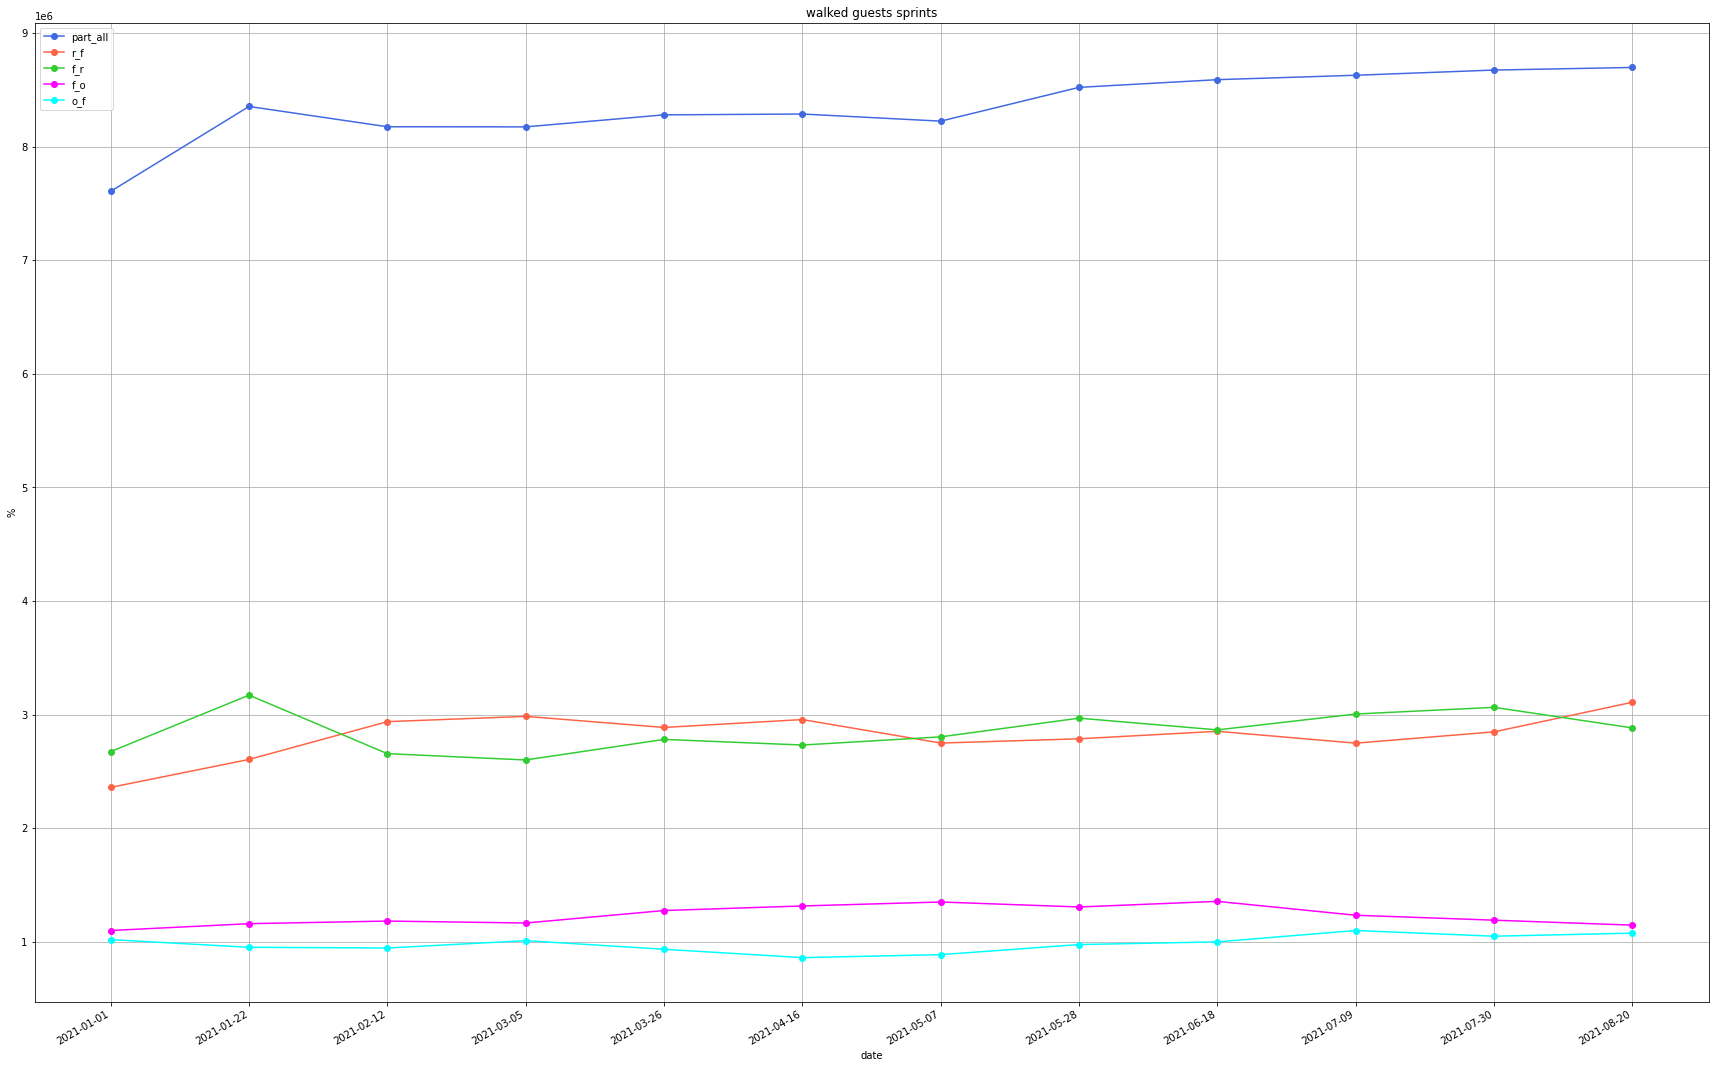

In [84]:
dates = df_sprints['sprint_start']
y1 = df_sprints['walked_qty']
y2 = df_sprints['r_f_qty']
y3 = df_sprints['f_r_qty']
y4 = df_sprints['f_o_qty']
y5 = df_sprints['o_f_qty']
y6 = df_sprints['cust_qty']
fig, ax = plt.subplots(figsize=(30,20))

plt.plot(dates, y1, color = 'royalblue', marker= 'o', label='part_all')
plt.plot(dates, y2, color = 'tomato', marker= 'o', label='r_f')
plt.plot(dates, y3, color = 'limegreen', marker= 'o', label='f_r')
plt.plot(dates, y4, color = 'magenta', marker= 'o', label='f_o')
plt.plot(dates, y5, color = 'cyan', marker= 'o', label='o_f')
# plt.plot(dates, y6, color = 'k', marker= 'o', label='o_f')
plt.legend()
plt.xlabel('date')
plt.ylabel('%')

plt.gcf().autofmt_xdate()
plt.grid()
plt.title('walked guests sprints')
plt.show()
fig.savefig("sprints_qty.png", dpi=1000, bbox_inches='tight')

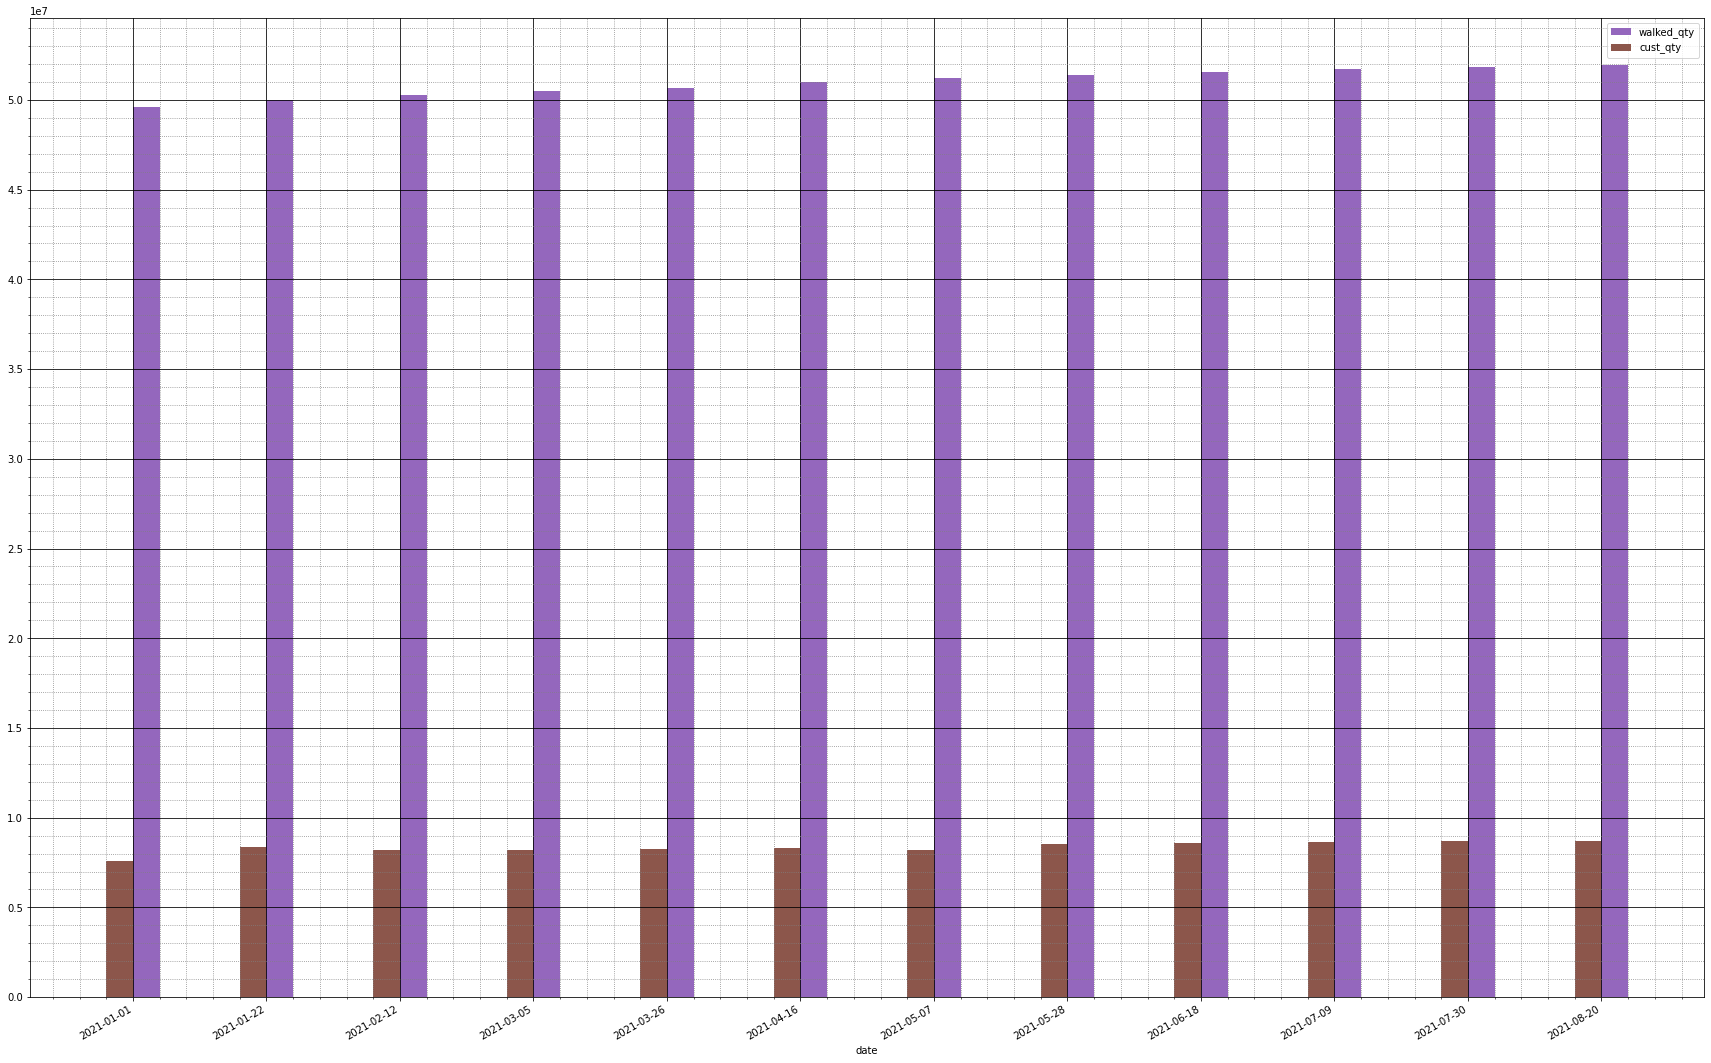

In [83]:
fig, ax = plt.subplots(figsize=(30,20))
width = 0.20

dates = df_sprints['sprint_start']
y1 = df_sprints['walked_qty']
y2 = df_sprints['cust_qty']

x = np.arange(len(dates))

ax.bar(x+width/2, y2, color='C4',label='walked_qty',width=width)
ax.bar(x-width/2, y1, color='C5',label='cust_qty',width=width)

import matplotlib.ticker as ticker
ax.yaxis.set_minor_locator(ticker.MultipleLocator(2000000))
ax.yaxis.set_major_locator(ticker.MultipleLocator(10000000))

ax.set_xlabel('date')
ax.set_xticks(x)
ax.set_xticklabels(dates)
ax.set_yticks([i for i in range(0, 55000000, 5000000)])
ax.legend()
plt.gcf().autofmt_xdate()
ax.grid(which='major', color='k')
ax.minorticks_on()
ax.grid(which='minor', color='gray', linestyle=':')

plt.show()
fig.savefig("sprints_qty_all.png", dpi=1000, bbox_inches='tight')

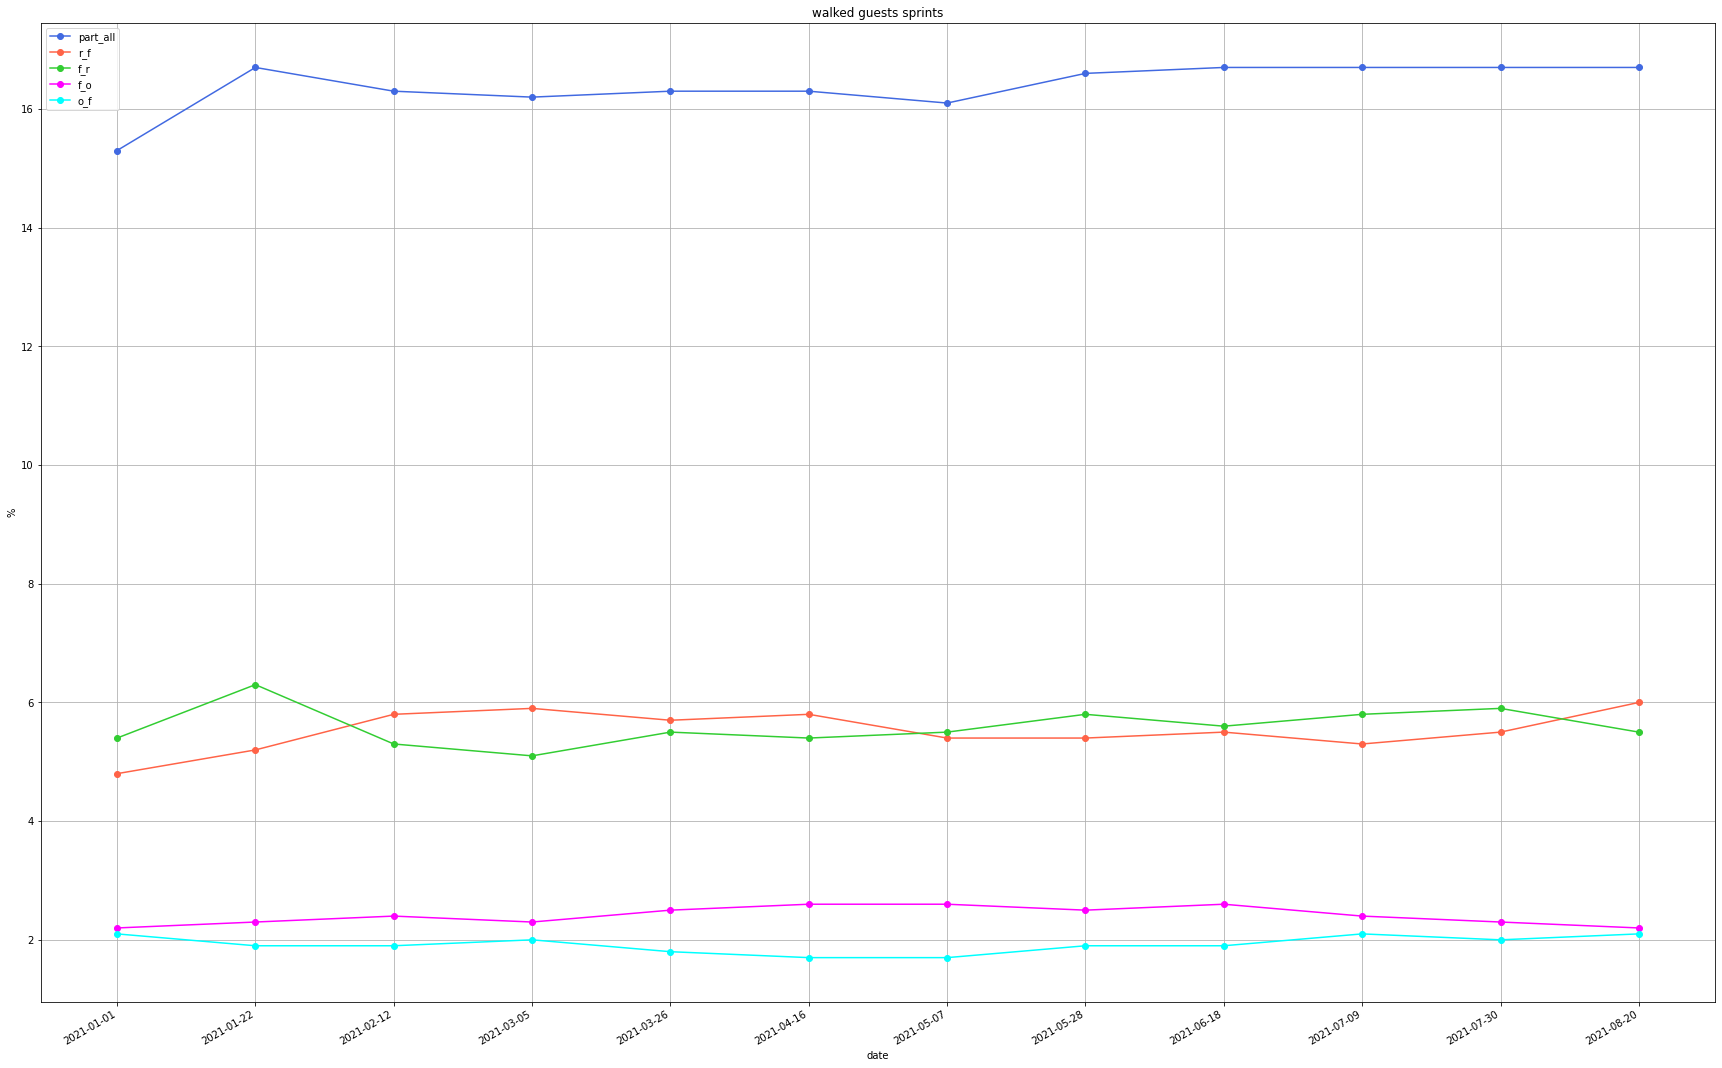

In [87]:
dates = df_sprints['sprint_start']
y1 = df_sprints['part_in_%']
y2 = df_sprints['r_f_in_%']
y3 = df_sprints['f_r_in_%']
y4 = df_sprints['f_o_in_%']
y5 = df_sprints['o_f_in_%']
plt.rcParams["figure.figsize"] = (30,20)

plt.plot(dates, y1, color = 'royalblue', marker= 'o', label='part_all')
plt.plot(dates, y2, color = 'tomato', marker= 'o', label='r_f')
plt.plot(dates, y3, color = 'limegreen', marker= 'o', label='f_r')
plt.plot(dates, y4, color = 'magenta', marker= 'o', label='f_o')
plt.plot(dates, y5, color = 'cyan', marker= 'o', label='o_f')
plt.legend()
plt.xlabel('date')
plt.ylabel('%')
plt.gcf().autofmt_xdate()
plt.grid()
plt.title('walked guests sprints')
plt.show()
fig.savefig("sprints.png", dpi=1000, bbox_inches='tight')

In [12]:
import numpy as np

In [9]:
df_dayly = pd.read_csv("statistic_usecases_dayly.csv", index_col=0)

In [78]:
df_dayly.head()

,part_in_%,walked_qty,cust_qty,r_f_qty,r_f_in_%,f_r_qty,f_r_in_%,f_o_qty,f_o_in_%,o_f_qty,o_f_in_%,sprint_start,sprint_end
0,1.27,658024,51919174,196756,0.38,198719,0.38,123056,0.24,110695,0.21,2021-08-20,2021-08-21
1,1.26,656742,51919171,176492,0.34,197965,0.38,114642,0.22,138479,0.27,2021-08-21,2021-08-22
2,1.37,709534,51918599,202639,0.39,214013,0.41,135595,0.26,126327,0.24,2021-08-22,2021-08-23
3,1.32,684030,51921829,202283,0.39,199022,0.38,127389,0.25,126079,0.24,2021-08-23,2021-08-24
4,1.29,668281,51921484,205231,0.40,177956,0.34,129424,0.25,126999,0.24,2021-08-24,2021-08-25


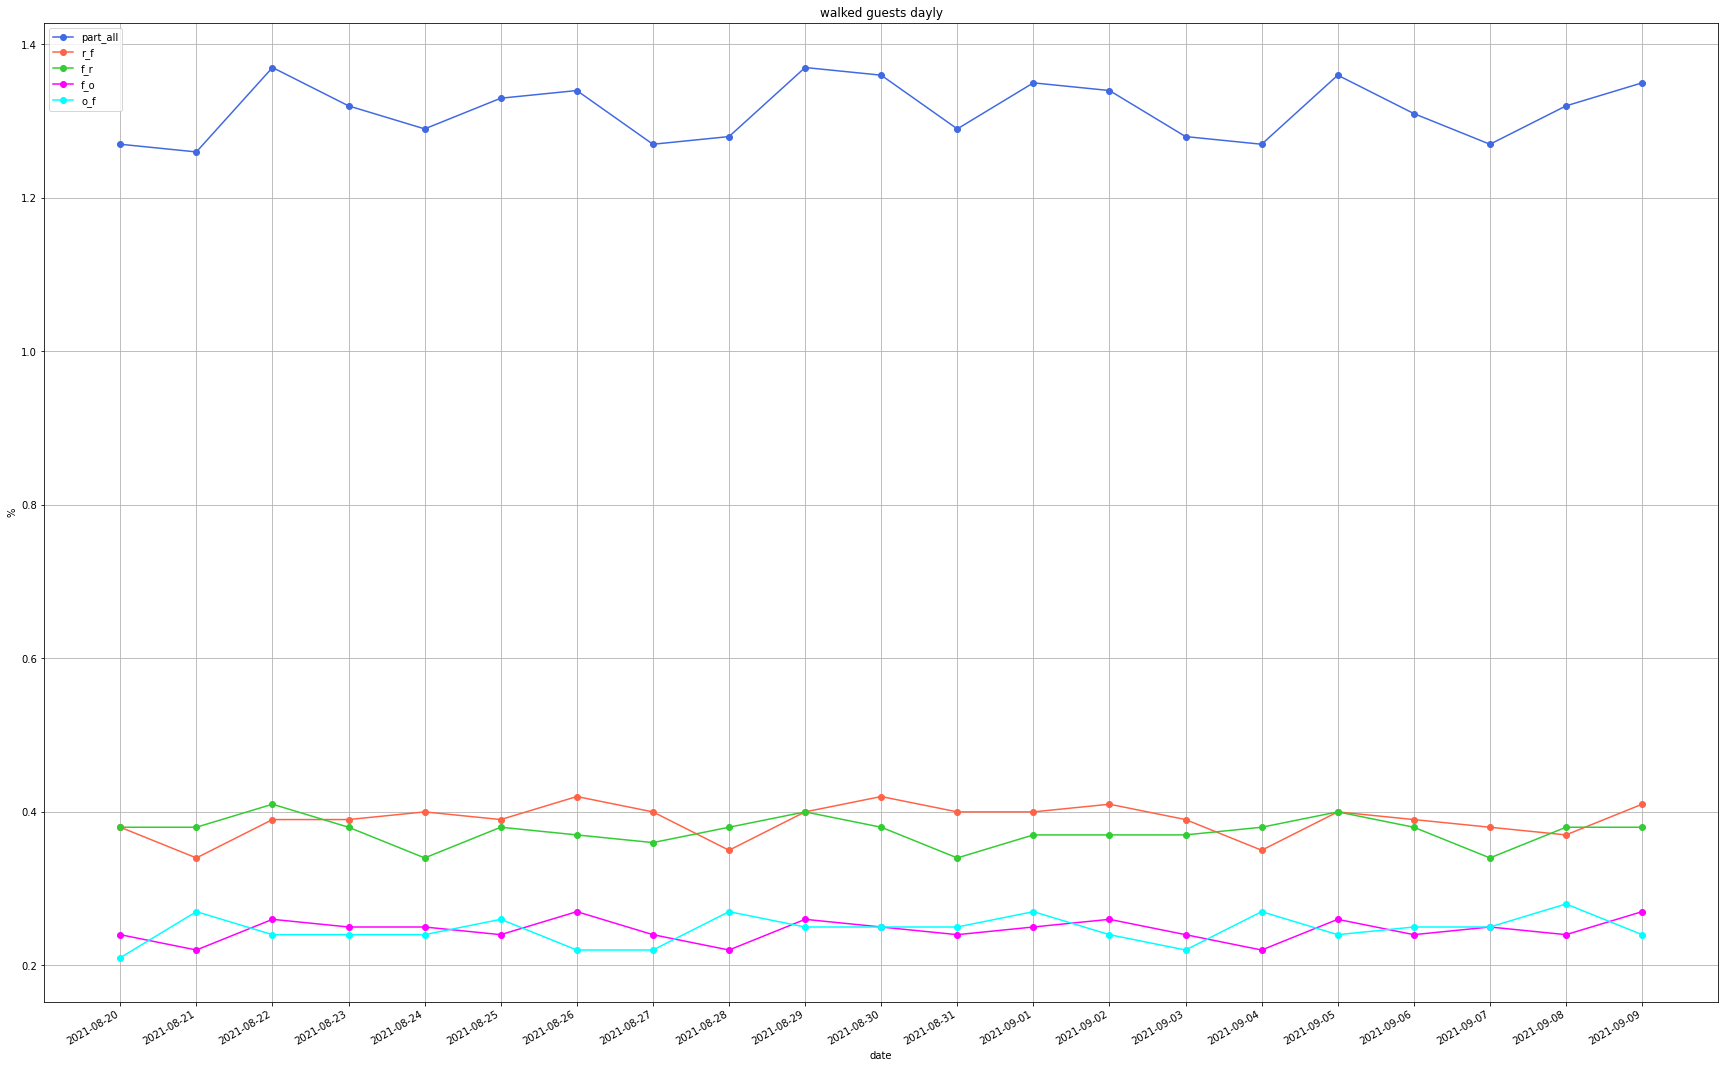

21/10/12 17:18:58 ERROR cluster.YarnClientSchedulerBackend: YARN application has exited unexpectedly with state FAILED! Check the YARN application logs for more details.
21/10/12 17:18:58 ERROR cluster.YarnClientSchedulerBackend: Diagnostics message: Attempt recovered after RM restartDue to executor failures all available nodes are blacklisted
21/10/12 17:18:58 ERROR client.TransportClient: Failed to send RPC RPC 4891112336351677490 to /192.168.234.54:58230: java.nio.channels.ClosedChannelException
java.nio.channels.ClosedChannelException
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(...)(Unknown Source)
21/10/12 17:18:58 ERROR cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Sending RequestExecutors(0,0,Map(),Set()) to AM was unsuccessful
java.io.IOException: Failed to send RPC RPC 4891112336351677490 to /192.168.234.54:58230: java.nio.channels.ClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.jav

In [88]:
dates = df_dayly['sprint_start']
y1 = df_dayly['part_in_%']
y2 = df_dayly['r_f_in_%']
y3 = df_dayly['f_r_in_%']
y4 = df_dayly['f_o_in_%']
y5 = df_dayly['o_f_in_%']
plt.rcParams["figure.figsize"] = (30,20)

plt.plot(dates, y1, color = 'royalblue', marker= 'o', label='part_all')
plt.plot(dates, y2, color = 'tomato', marker= 'o', label='r_f')
plt.plot(dates, y3, color = 'limegreen', marker= 'o', label='f_r')
plt.plot(dates, y4, color = 'magenta', marker= 'o', label='f_o')
plt.plot(dates, y5, color = 'cyan', marker= 'o', label='o_f')
plt.legend()
plt.xlabel('date')
plt.ylabel('%')
plt.gcf().autofmt_xdate()
plt.grid()
plt.title('walked guests dayly')
plt.show()
fig.savefig("dayly.png", dpi=1000, bbox_inches='tight')